# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### Answer 

The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    f1_score,
    roc_auc_score,
    log_loss,
    roc_curve,
    recall_score,
    precision_recall_curve, 
    average_precision_score
)
import time

from sklearn.datasets import load_digits
import os

In [2]:
os.makedirs('images', exist_ok=True)
np.set_printoptions(precision=4, suppress=True)

# Display with all columns visible (no clipping)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
bankdf = pd.read_csv('data/bank-additional-full.csv', sep = ';')
rows, cols = bankdf.shape
print(f"Dataset contains {rows:,} rows and {cols} columns")

Dataset contains 41,188 rows and 21 columns


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### 3.1 Data Cleaning and Preparation

Prepare the dataset for modeling through systematic cleaning and transformation:
1. **Column Renaming**: Convert to descriptive snake_case names
2. **Data Exploration**: Understand data types and distributions  
3. **Missing Values**: Handle 'unknown' and placeholder values
4. **Feature Engineering**: Create categorical variables from continuous ones




   
##### 3.1.1 Rename Columns


In [4]:
# Rename columns for clarity: use descriptive, consistent names so they are easier to understand and work with.
bankdf.rename(columns={
    'age': 'age',
    'job': 'job_type',
    'marital': 'marital_status',
    'education': 'education_level',
    'default': 'has_credit_default',
    'housing': 'has_housing_loan',
    'loan': 'has_personal_loan',
    'contact': 'contact_communication_type',
    'month': 'last_contact_month',
    'day_of_week': 'last_contact_day_of_week',
    'duration': 'last_contact_duration_seconds',
    'campaign': 'current_campaign_num_contacts',
    'pdays': 'previous_campaign_days_since_contact',
    'previous': 'previous_campaign_num_contacts',
    'poutcome': 'previous_campaign_outcome',
    'emp.var.rate': 'employment_variation_rate',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'euribor3m': 'euribor_3_month_rate',
    'nr.employed': 'quarterly_avg_employed',
    'y': 'has_subscribed_term_deposit'
}, inplace=True)

##### 3.1.2 Explore Data Structure

In [5]:
# Transpose the rows to columns so it is easy to inspect all the columns
sample_df = bankdf.sample(5)
sample_df.index.name = "Row Num"
sample_df_T = sample_df.T
# sort the column names for easy inspection
sample_df_T = sample_df_T.sort_index(axis=0)
sample_df_T

Row Num,13141,20337,10428,39461,2055
age,43,38,24,68,35
consumer_confidence_index,-42.7,-36.1,-41.8,-34.6,-36.4
consumer_price_index,93.918,93.444,94.465,93.749,93.994
contact_communication_type,cellular,cellular,telephone,cellular,telephone
current_campaign_num_contacts,1,1,2,1,3
education_level,basic.4y,university.degree,basic.9y,basic.4y,university.degree
employment_variation_rate,1.4,1.4,1.4,-1.8,1.1
euribor_3_month_rate,4.962,4.966,4.96,0.644,4.857
has_credit_default,no,no,unknown,no,no
has_housing_loan,yes,no,no,yes,yes


In [6]:
# print the data type and unique values in each column
for col in bankdf.columns.sort_values():
    value_counts = bankdf[col].value_counts(dropna=False)
    print(f"Type = {bankdf[col].dtype}, Unique values = {len(value_counts)}")
    print(value_counts)
    print("-" * 30)

Type = int64, Unique values = 78
age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64
------------------------------
Type = float64, Unique values = 26
consumer_confidence_index
-36.4    7763
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: count, dtype: int64
------------------------------
Type = float64, Unique values = 26
consumer_price_index
93.994    7763
93.918    6685
92.893    5794
93.444    5175
94.465    4374
93.200    3616
93.075    2458
92.201     770
92.963     715
92.431     447
92.649     357
94.215     311
94.199     303
92.843     282
92.379     267
93.369    

##### 3.1.3 Handle Missing and Unknown Values
Replace categorical values that are not useful for modeling (such as 'unknown', 'nonexistent', and placeholder values like 999) with null values for proper handling during analysis.

In [7]:
# Function to replace specific values with NaN in a specific column
def replace_value_with_null(df, column_name, value_to_replace):
    count = (df[column_name] == value_to_replace).sum()
    df[column_name] = df[column_name].replace(value_to_replace, np.nan)
    print(f"Replaced {count} '{value_to_replace}' values in '{column_name}' with null")
    return df

# Apply the function to clean the data
bankdf = replace_value_with_null(bankdf, 'job_type', 'unknown')
bankdf = replace_value_with_null(bankdf, 'marital_status', 'unknown')
bankdf = replace_value_with_null(bankdf, 'education_level', 'unknown')
bankdf = replace_value_with_null(bankdf, 'has_credit_default', 'unknown')
bankdf = replace_value_with_null(bankdf, 'has_housing_loan', 'unknown')
bankdf = replace_value_with_null(bankdf, 'has_personal_loan', 'unknown')
bankdf = replace_value_with_null(bankdf, 'previous_campaign_outcome', 'nonexistent')
bankdf = replace_value_with_null(bankdf, 'previous_campaign_days_since_contact', 999)
bankdf = replace_value_with_null(bankdf, 'previous_campaign_num_contacts', 0)

Replaced 330 'unknown' values in 'job_type' with null
Replaced 80 'unknown' values in 'marital_status' with null
Replaced 1731 'unknown' values in 'education_level' with null
Replaced 8597 'unknown' values in 'has_credit_default' with null
Replaced 990 'unknown' values in 'has_housing_loan' with null
Replaced 990 'unknown' values in 'has_personal_loan' with null
Replaced 35563 'nonexistent' values in 'previous_campaign_outcome' with null
Replaced 39673 '999' values in 'previous_campaign_days_since_contact' with null
Replaced 35563 '0' values in 'previous_campaign_num_contacts' with null


##### 3.1.4 Analyze Missing Values

Analyze and visualize missing values in our dataset after data cleaning. This helps us understand the extent of missing data and plan appropriate handling strategies for machine learning models.

In [8]:
# Fetch the columns with null values
def get_missing_values(df):
    dataNullStats = df.isnull().agg(['sum', 'mean'])
    dataNullStats = dataNullStats.T
    return dataNullStats[dataNullStats['sum'] > 0]

print(get_missing_values(bankdf))

                                          sum      mean
job_type                                330.0  0.008012
marital_status                           80.0  0.001942
education_level                        1731.0  0.042027
has_credit_default                     8597.0  0.208726
has_housing_loan                        990.0  0.024036
has_personal_loan                       990.0  0.024036
previous_campaign_days_since_contact  39673.0  0.963217
previous_campaign_num_contacts        35563.0  0.863431
previous_campaign_outcome             35563.0  0.863431


Create a heatmap to visualize the pattern of missing values across the dataset. This helps identify if missing values are randomly distributed or follow specific patterns.

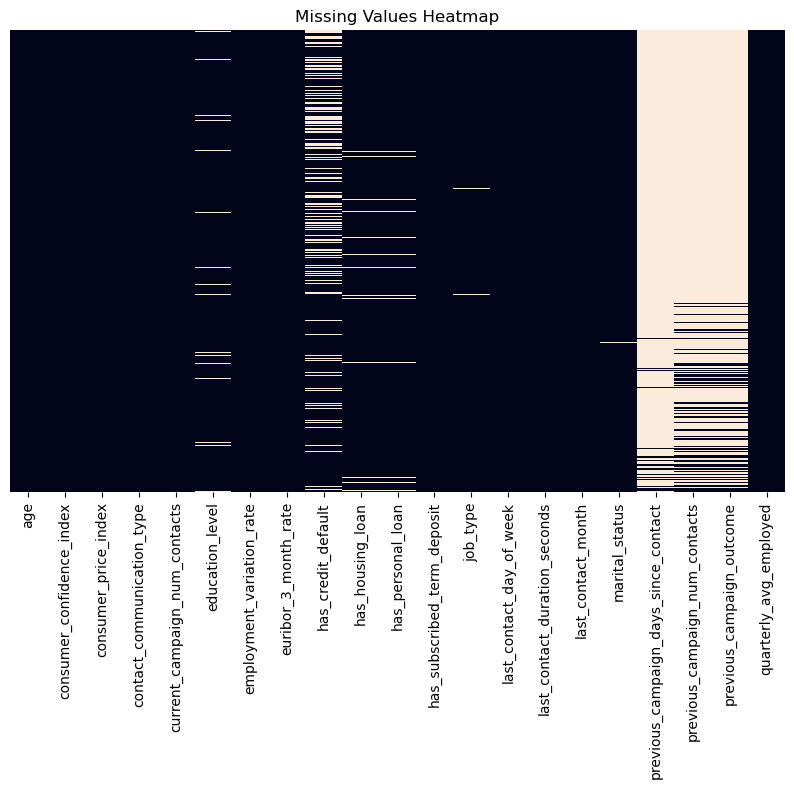

In [9]:
# Visualize the missing values with heatmap
def plot_missing_values_heatmap():
    # Sort columns alphabetically
    sorted_cols = sorted(bankdf.columns)
    plt.figure(figsize=(10, 6))
    sns.heatmap(bankdf[sorted_cols].isnull(), cbar=False, yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()

plot_missing_values_heatmap()

##### 3.1.5 Detect and Remove Duplicates

Identify and handle any duplicate rows in the dataset. Duplicate records can bias our analysis and model training, so it's important to detect and remove them.

In [10]:
# look for duplicated rows
num_duplicates = bankdf.duplicated().sum()
if num_duplicates > 0:
    print(f"Number of duplicated rows = {num_duplicates}")
    bankdf = bankdf.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicate rows found.")

rows, cols = bankdf.shape
print(f"Dataset contains {rows:,} rows and {cols} columns")

Number of duplicated rows = 12
Duplicates removed.
Dataset contains 41,176 rows and 21 columns


#### 3.2 Correlation Analysis

Create and visualize a correlation matrix for all numeric variables to identify:
- **Strong correlations** that might indicate multicollinearity issues
- **Relationships** between economic indicators
- **Redundant features** that can be removed to improve model performance

This analysis will guide our feature selection decisions.

##### 3.2.1 Correlation Matrix Visualization

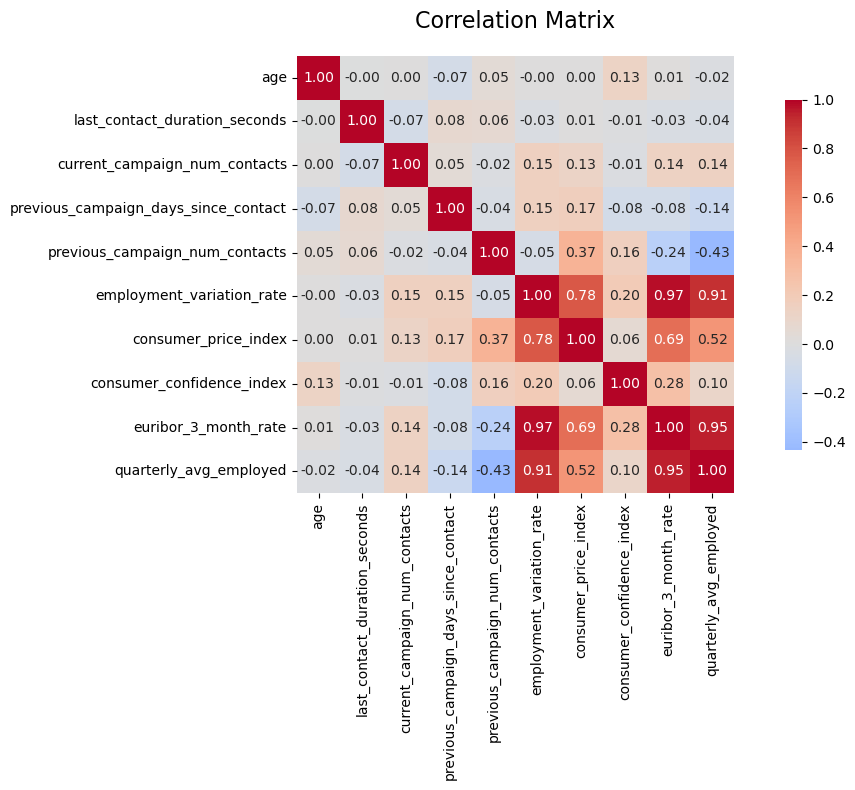

In [11]:
def create_correlation_matrix(df):
    """
    Create a simple correlation matrix visualization for numeric columns.
    """
    # Select numeric columns for correlation analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Calculate correlation matrix
    correlation_matrix = df[numeric_cols].corr()
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Simple heatmap
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'shrink': 0.8})
    
    plt.title('Correlation Matrix', fontsize=16, pad=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # Use bbox_inches to ensure everything fits
    plt.tight_layout()
    plt.show()

# Call the function to display the correlation matrix
create_correlation_matrix(bankdf)

##### 3.2.2 Key Observations from Correlation Analysis

Through the correlation matrix analysis, several important observations emerge regarding the relationships between variables in the bank marketing dataset:

**Strong Positive Correlations Observed:**
- Employment variation rate and euribor 3-month rate show a very strong positive correlation (0.97), suggesting that as employment rates increase, the bank's lending rates also tend to increase.

- Employment variation rate and quarterly average employed demonstrate a strong positive correlation (0.91), indicating that higher employment rates are associated with increased average quarterly employment levels.

**Moderate Correlations Observed:**
- Employment variation rate and consumer price index exhibit a moderate positive correlation (0.78), revealing that employment rate increases are often accompanied by rising prices of goods and services.


##### 3.2.3 Feature Selection Based on Correlation Analysis

**Multicollinearity Concerns:**

Given the strong correlations observed above, we should consider removing redundant features to improve model performance and interpretability:

**Recommended Features to Remove:**

1. **euribor_3_month_rate** - Remove due to very high correlation (0.97) with employment_variation_rate
   - These variables carry essentially the same information
   - Keeping both would introduce multicollinearity issues

2. **quarterly_avg_employed** - Consider removing due to high correlation (0.91) with employment_variation_rate
   - Both represent employment-related economic indicators
   - employment_variation_rate might be more informative as it shows rate of change

#### Outlier Detection and Removal Functions

Define utility functions for outlier analysis and removal:

- **`plot_boxplot()`**: Creates boxplots with percentile reference lines to visualize data distribution and identify outliers
- **`filter_column_by_percentile()`**: Filters data to remove extreme outliers based on specified percentile thresholds

These functions help us handle outliers that could negatively impact model performance.


=== Analyzing `age` ===


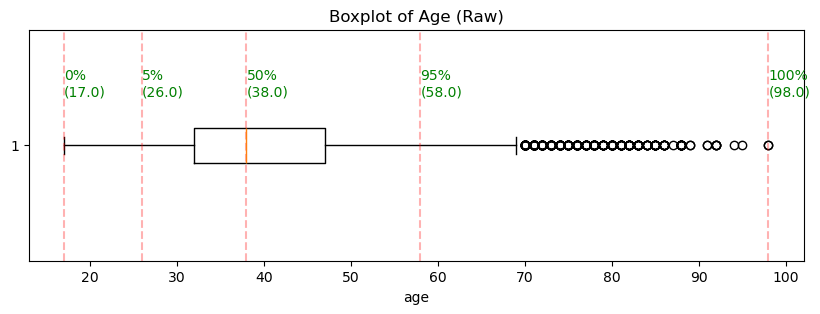

Filtering `age` between 2th and 97th percentiles: [24.00, 59.00]
Total rows: 41176, Non-NaN in `age` before: 41176, after: 39379

After filtering - Raw values:


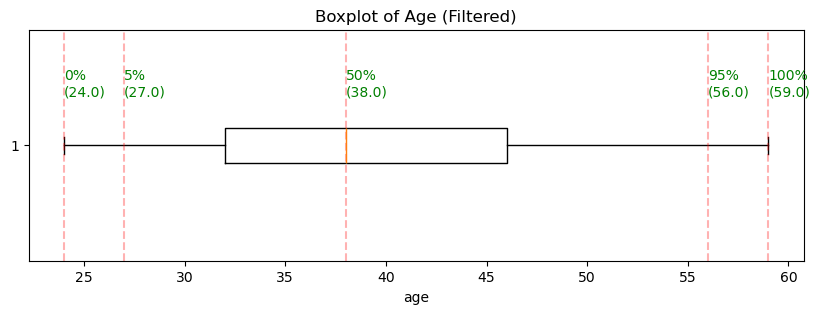


=== Analyzing `current_campaign_num_contacts` ===


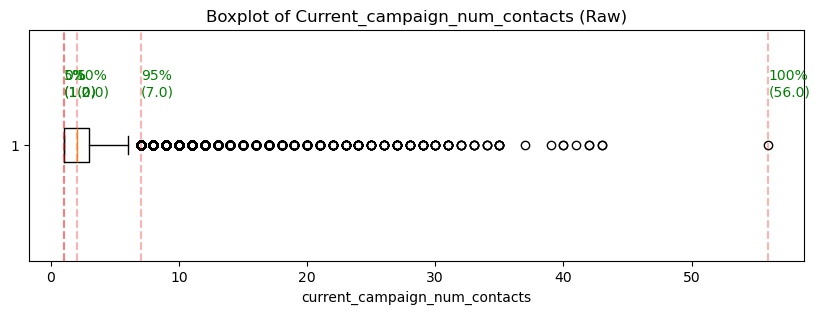

Filtering `current_campaign_num_contacts` between 1th and 95th percentiles: [1.00, 7.00]
Total rows: 41176, Non-NaN in `current_campaign_num_contacts` before: 41176, after: 39399

After filtering - Raw values:


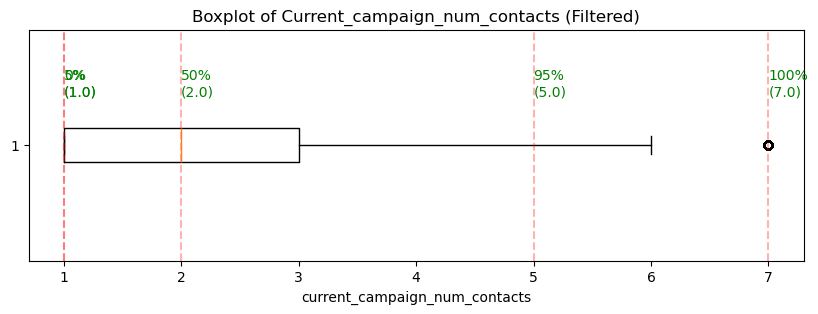


=== Analyzing `last_contact_duration_seconds` ===


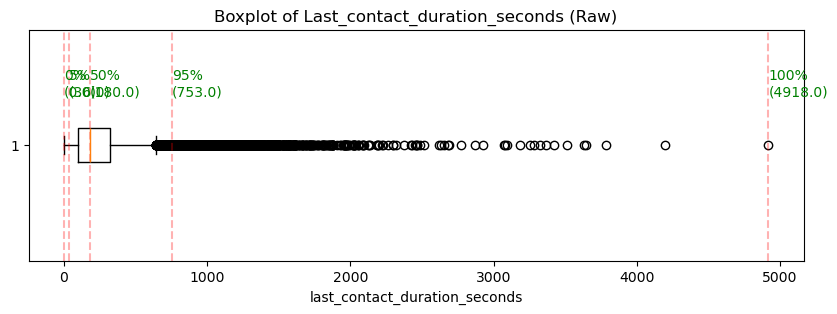

Filtering `last_contact_duration_seconds` between 10th and 95th percentiles: [59.00, 753.00]
Total rows: 41176, Non-NaN in `last_contact_duration_seconds` before: 41172, after: 35076

After filtering - Raw values:


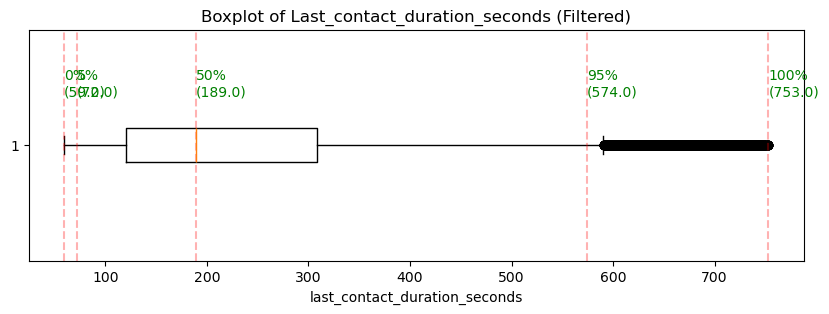

In [12]:
# remove outliers in age plot box
def plot_boxplot(df, col, percentiles=[0, 5, 50, 95, 100], title_suffix="", log10=False):
    clean = df[col].dropna()
    
    if log10:
        # Apply log10 transformation (add 1 to handle zero values)
        plot_vals = np.log10(clean + 1)
        xlabel = f'Log10({col} + 1)'
    else:
        # Use raw values
        plot_vals = clean
        xlabel = col
    
    pct_vals = np.percentile(plot_vals, percentiles)
    labels = [f"{p}%" for p in percentiles]

    plt.figure(figsize=(10, 3))
    plt.boxplot(plot_vals, vert=False)
    for p, label in zip(pct_vals, labels):
        plt.axvline(p, color='red', linestyle='--', alpha=0.3)
        plt.text(p, 1.2, f'{label}\n({p:.1f})', color='green', ha='left', va='bottom', fontsize=10)
    plt.title(f'Boxplot of {col.capitalize()} {title_suffix}')
    plt.xlabel(xlabel)
    plt.show()

def filter_column_by_percentile(df, col, lower=5, upper=95):
    """Return a copy of df with values outside percentiles set to NaN for the given column."""
    clean = df[col].dropna()
    clean = clean[clean > 0]
    low, high = np.percentile(clean, [lower, upper])
    filtered = clean[(clean >= low) & (clean <= high)]
    print(f"Filtering `{col}` between {lower}th and {upper}th percentiles: [{low:.2f}, {high:.2f}]")
    print(f"Total rows: {len(df)}, Non-NaN in `{col}` before: {clean.count()}, after: {filtered.count()}\n")
    result = df.copy()
    result[col] = filtered
    return result

print("\n=== Analyzing `age` ===")
plot_boxplot(bankdf, 'age', title_suffix="(Raw)", log10=False)
bankdf = filter_column_by_percentile(bankdf, 'age', 2, 97)
print("After filtering - Raw values:")
plot_boxplot(bankdf, 'age', title_suffix="(Filtered)", log10=False)

print("\n=== Analyzing `current_campaign_num_contacts` ===")
plot_boxplot(bankdf, 'current_campaign_num_contacts', title_suffix="(Raw)", log10=False)
bankdf = filter_column_by_percentile(bankdf, 'current_campaign_num_contacts', 1, 95)
print("After filtering - Raw values:")
plot_boxplot(bankdf, 'current_campaign_num_contacts', title_suffix="(Filtered)", log10=False)

print("\n=== Analyzing `last_contact_duration_seconds` ===")
plot_boxplot(bankdf, 'last_contact_duration_seconds', title_suffix="(Raw)", log10=False)
bankdf = filter_column_by_percentile(bankdf, 'last_contact_duration_seconds', 10, 95)
print("After filtering - Raw values:")
plot_boxplot(bankdf, 'last_contact_duration_seconds', title_suffix="(Filtered)", log10=False)

#### Handle Missing Values in Critical Columns

Remove rows with missing values in essential columns for modeling. For this analysis, we require complete data for:
- **Age**: Core demographic information
- **Current campaign contacts**: Essential campaign behavior data  
- **Last contact duration**: Key predictor for subscription likelihood

Missing values in these columns would significantly impact model performance.

In [13]:
# drop rows with null values
print("Dropped", bankdf['age'].isna().sum(), "rows with missing 'age'.")
bankdf.dropna(subset=['age'], inplace=True)
print(f"Dataset shape: {bankdf.shape[0]} rows, {bankdf.shape[1]} columns")

print("Dropped", bankdf['current_campaign_num_contacts'].isna().sum(), "rows with missing 'current_campaign_num_contacts'.")
bankdf.dropna(subset=['current_campaign_num_contacts'], inplace=True)
print(f"Dataset shape: {bankdf.shape[0]} rows, {bankdf.shape[1]} columns")

print("Dropped", bankdf['last_contact_duration_seconds'].isna().sum(), "rows with missing 'last_contact_duration_seconds'.")
bankdf.dropna(subset=['last_contact_duration_seconds'], inplace=True)
print(f"Dataset shape: {bankdf.shape[0]} rows, {bankdf.shape[1]} columns")

defaulted_records = bankdf[bankdf['has_credit_default'] == 'yes']
print(f"Dropped {defaulted_records.shape[0]:,} rows with 'has_credit_default' = 'yes'")
bankdf = bankdf.drop(index=defaulted_records.index).reset_index(drop=True)
print(f"Dataset shape: {bankdf.shape[0]} rows, {bankdf.shape[1]} columns")

Dropped 1797 rows with missing 'age'.
Dataset shape: 39379 rows, 21 columns
Dropped 1736 rows with missing 'current_campaign_num_contacts'.
Dataset shape: 37643 rows, 21 columns
Dropped 5166 rows with missing 'last_contact_duration_seconds'.
Dataset shape: 32477 rows, 21 columns
Dropped 3 rows with 'has_credit_default' = 'yes'
Dataset shape: 32474 rows, 21 columns


#### Data Preprocessing Summary

**Dataset Transformation Overview:**

The dataset underwent systematic preprocessing to ensure data quality and completeness:

- **Initial Dataset**: 41,188 rows × 21 columns
- **Duplicate Removal**: 12 duplicate records identified and removed
- **Missing Value and Outlier Handling**: Rows with critical missing/outlier data were excluded:
  - 748 rows: missing age information
  - 1,763 rows: missing current campaign contact count
  - 2,224 rows: missing last contact duration
  - 3 rows: with credit defaults

**Final Preprocessed Dataset**: 35,266 rows × 21 columns

This represents an 11.5% reduction in dataset size while maintaining data integrity for reliable model training and evaluation.

#### 3.3 Feature Engineering

Transform raw data into model-ready features to improve prediction performance and business interpretability.

1. **Previous Contact Timing**: Convert days since contact → categorical bins
2. **Call Duration**: Convert seconds → minute-based categories  
3. **Feature Selection**: Remove highly correlated economic indicators

##### 3.3.1 Previous Contact Timing

Convert `previous_campaign_days_since_contact` into meaningful categories:
- **Same Day (0)**: Immediate follow-up
- **Within Week (1-7)**: Recent contact
- **Within Month (8-30)**: Medium-term follow-up  
- **Never**: No previous contact (was 999)

In [14]:
# Create categorical bins for previous contact timing
conditions = [
    bankdf['previous_campaign_days_since_contact'] <= 1,    # Next day
    (bankdf['previous_campaign_days_since_contact'] > 1) & (bankdf['previous_campaign_days_since_contact'] <= 7),    # Within week
    (bankdf['previous_campaign_days_since_contact'] > 7) & (bankdf['previous_campaign_days_since_contact'] <= 30)    # Within month
]
choices = ['2d', '3_7d', '7d_plus']
bankdf['previous_contact_timing_bin'] = np.select(conditions, choices, default='never')

print("Previous contact timing distribution:")
print(bankdf['previous_contact_timing_bin'].value_counts())

# Drop original column
bankdf.drop(columns=['previous_campaign_days_since_contact'], inplace=True)
print(f"Dataset shape: {bankdf.shape}")

Previous contact timing distribution:
previous_contact_timing_bin
never      31360
3_7d         830
7d_plus      250
2d            34
Name: count, dtype: int64
Dataset shape: (32474, 21)


##### 3.3.2 Call Duration Binning

Transform `last_contact_duration_seconds` into engagement-based categories:
- **Short (0-3 min)**: Quick interactions
- **Medium (3-8 min)**: Engaged conversations
- **Long (8+ min)**: Deep discussions

Granular minute-based bins capture different customer engagement levels better than continuous seconds.

In [15]:
# Create minute-based categorical bins for call duration
bins = [0, 60, 120, 180, 240, 300, 360, 480, 600, np.inf]
labels = [
    '0-1 min', '1-2 min', '2-3 min', '3-4 min', '4-5 min',
    '5-6 min', '6-8 min', '8-10 min', '10+ min'
]


bankdf['last_contact_duration_bin'] = pd.cut(bankdf['last_contact_duration_seconds'], 
                                           bins=bins, labels=labels, right=False)

print("Call duration distribution:")
print(bankdf['last_contact_duration_bin'].value_counts().sort_index())

# Drop original column
bankdf.drop(columns=['last_contact_duration_seconds'], inplace=True)
print(f"Dataset shape: {bankdf.shape}")

Call duration distribution:
last_contact_duration_bin
0-1 min      122
1-2 min     7970
2-3 min     7222
3-4 min     5113
4-5 min     3549
5-6 min     2475
6-8 min     3020
8-10 min    1677
10+ min     1326
Name: count, dtype: int64
Dataset shape: (32474, 21)


##### 3.3.3 Remove Correlated Features

Remove redundant economic indicators to prevent multicollinearity:

- **`euribor_3_month_rate`**: 97% correlation with `employment_variation_rate`
- **`quarterly_avg_employed`**: 91% correlation with `employment_variation_rate`

Keeping `employment_variation_rate` as it captures rate of change (more informative than absolute values).

In [16]:
# Remove highly correlated features to prevent multicollinearity
features_to_remove = ['euribor_3_month_rate', 'quarterly_avg_employed']

print("Removing features with high correlation (>0.90):")
for feature in features_to_remove:
    if feature in bankdf.columns:
        print(f"- Dropping '{feature}'")
    else:
        print(f"- '{feature}' already removed")

bankdf.drop(columns=[f for f in features_to_remove if f in bankdf.columns], inplace=True)
print(f"Dataset shape after feature removal: {bankdf.shape}")

Removing features with high correlation (>0.90):
- Dropping 'euribor_3_month_rate'
- Dropping 'quarterly_avg_employed'
Dataset shape after feature removal: (32474, 19)


##### 3.3.4 Feature Engineering Summary

**Transformations Applied:**

| Original Feature | New Feature | Change |
|------------------|-------------|---------|
| `previous_campaign_days_since_contact` | `previous_contact_timing_bin` | 4 categories: same_day, within_week, within_month, never |
| `last_contact_duration_seconds` | `last_contact_duration_bin` | 9 minute-based bins: 0-1 min to 10+ min |
| `euribor_3_month_rate` | Removed | High correlation (97%) |
| `quarterly_avg_employed` | Removed | High correlation (91%) |

**Benefits:** Enhanced interpretability, reduced multicollinearity, better model performance.

=== Feature Engineering Complete ===
Final dataset shape: (32474, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32474 entries, 0 to 32473
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   age                             32474 non-null  float64 
 1   job_type                        32228 non-null  object  
 2   marital_status                  32414 non-null  object  
 3   education_level                 31211 non-null  object  
 4   has_credit_default              25671 non-null  object  
 5   has_housing_loan                31693 non-null  object  
 6   has_personal_loan               31693 non-null  object  
 7   contact_communication_type      32474 non-null  object  
 8   last_contact_month              32474 non-null  object  
 9   last_contact_day_of_week        32474 non-null  object  
 10  current_campaign_num_contacts   32474 non-null  float64 
 11  previous_c

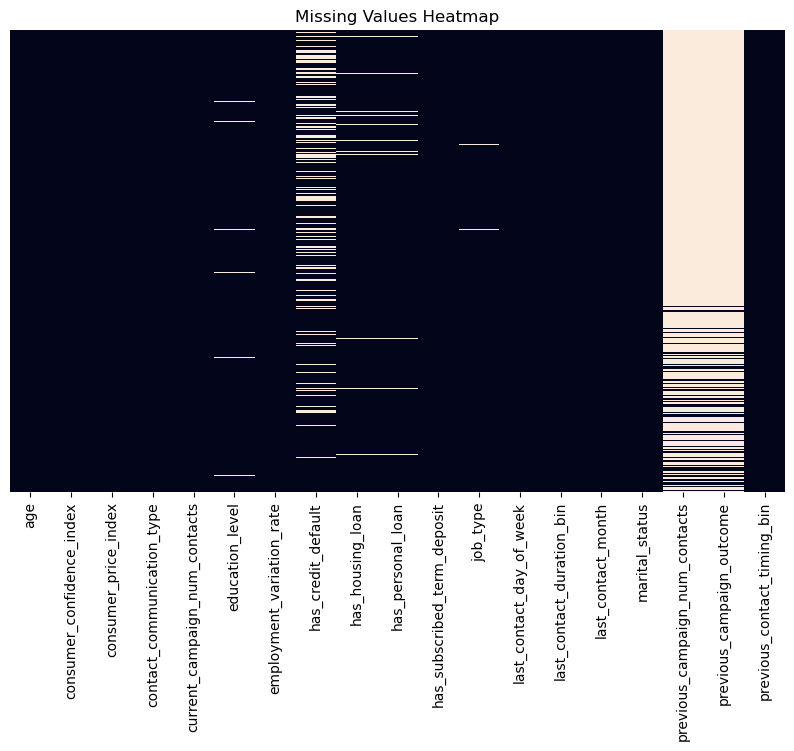

,sum,mean
job_type,246.0,0.007575
marital_status,60.0,0.001848
education_level,1263.0,0.038893
has_credit_default,6803.0,0.209491
has_housing_loan,781.0,0.024050
has_personal_loan,781.0,0.024050
previous_campaign_num_contacts,28108.0,0.865554
previous_campaign_outcome,28108.0,0.865554


In [17]:
# Final dataset inspection after feature engineering
print("=== Feature Engineering Complete ===")
print(f"Final dataset shape: {bankdf.shape}")
bankdf.info()
plot_missing_values_heatmap()
get_missing_values(bankdf)

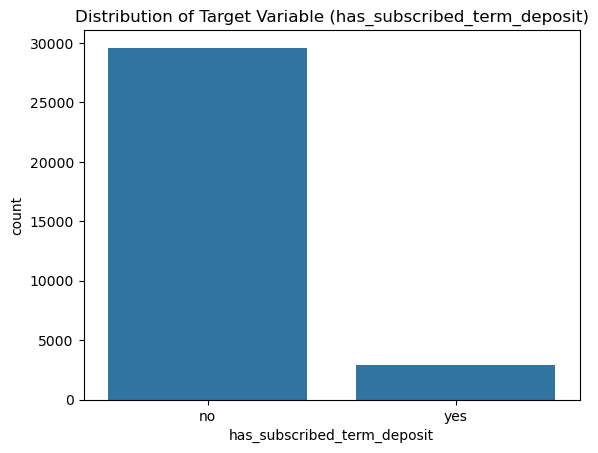

In [18]:
# plot the distribution of the target variable 'has_subscribed_term_deposit'
sns.countplot(x='has_subscribed_term_deposit', data=bankdf)
plt.title('Distribution of Target Variable (has_subscribed_term_deposit)')
plt.show()


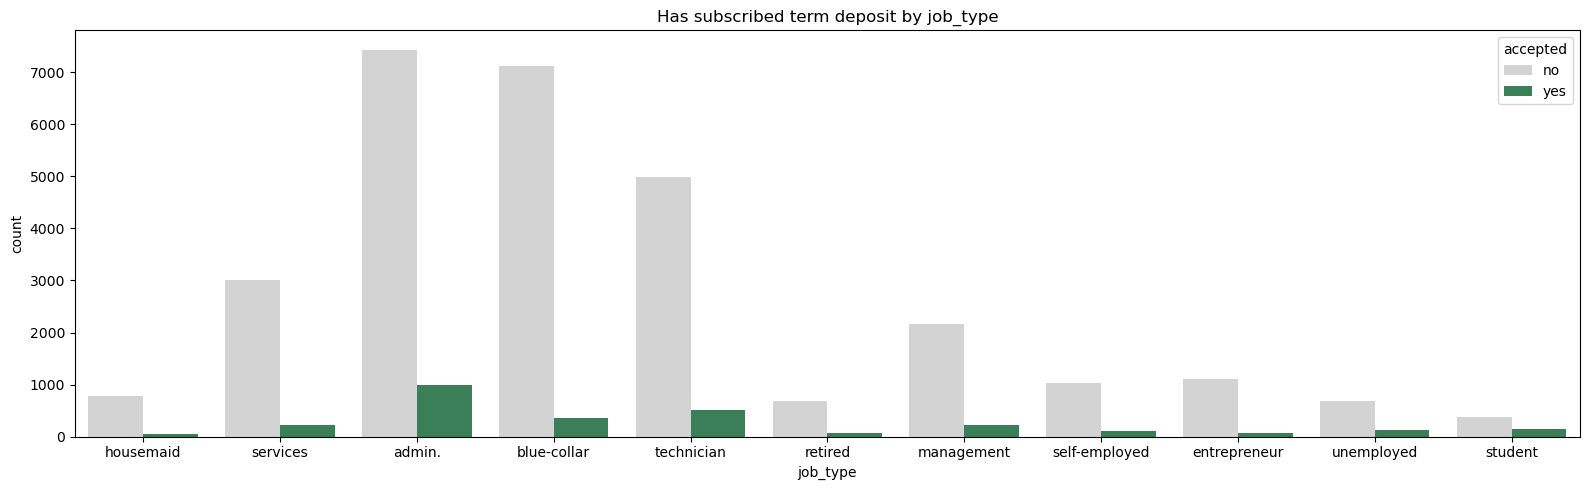

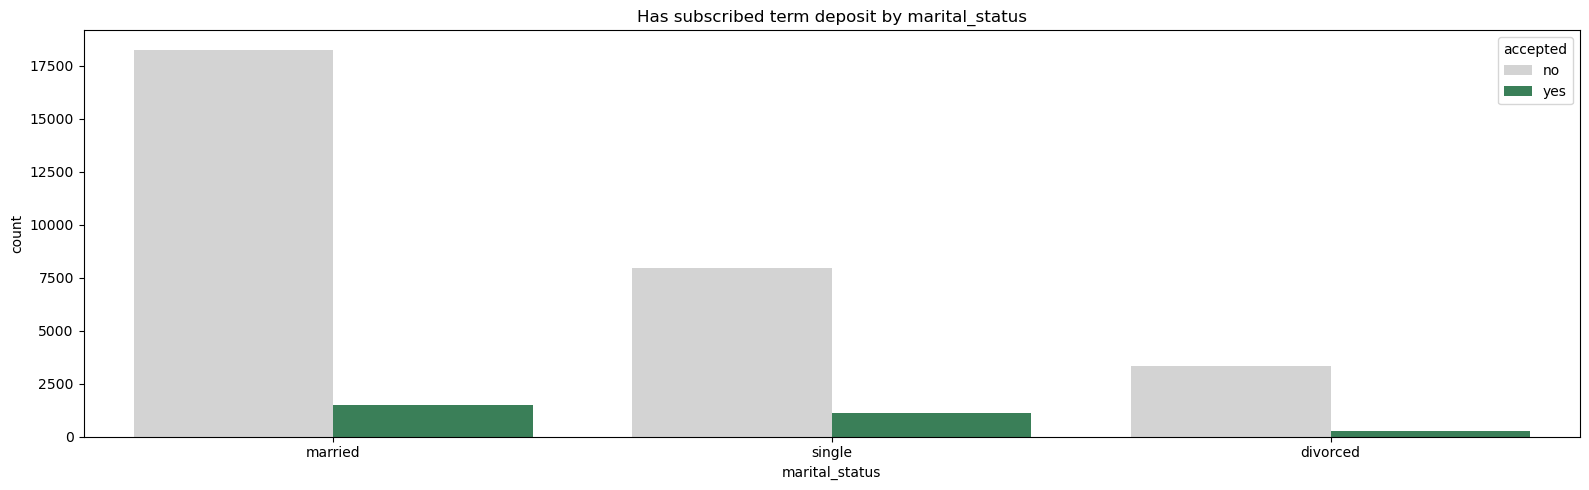

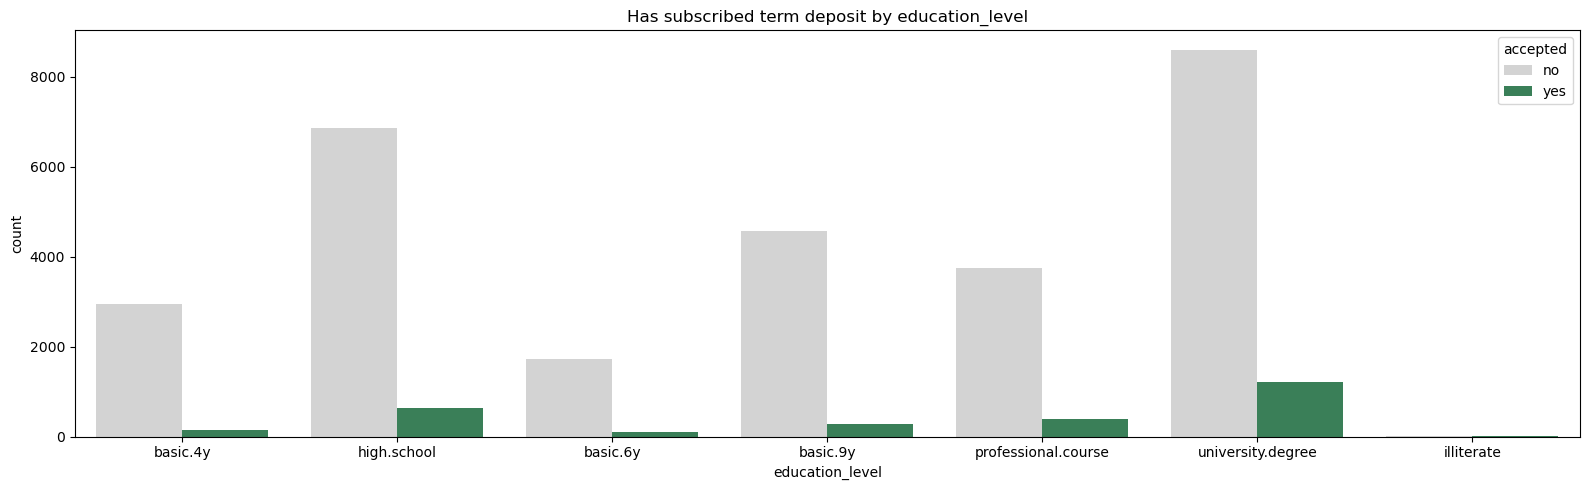

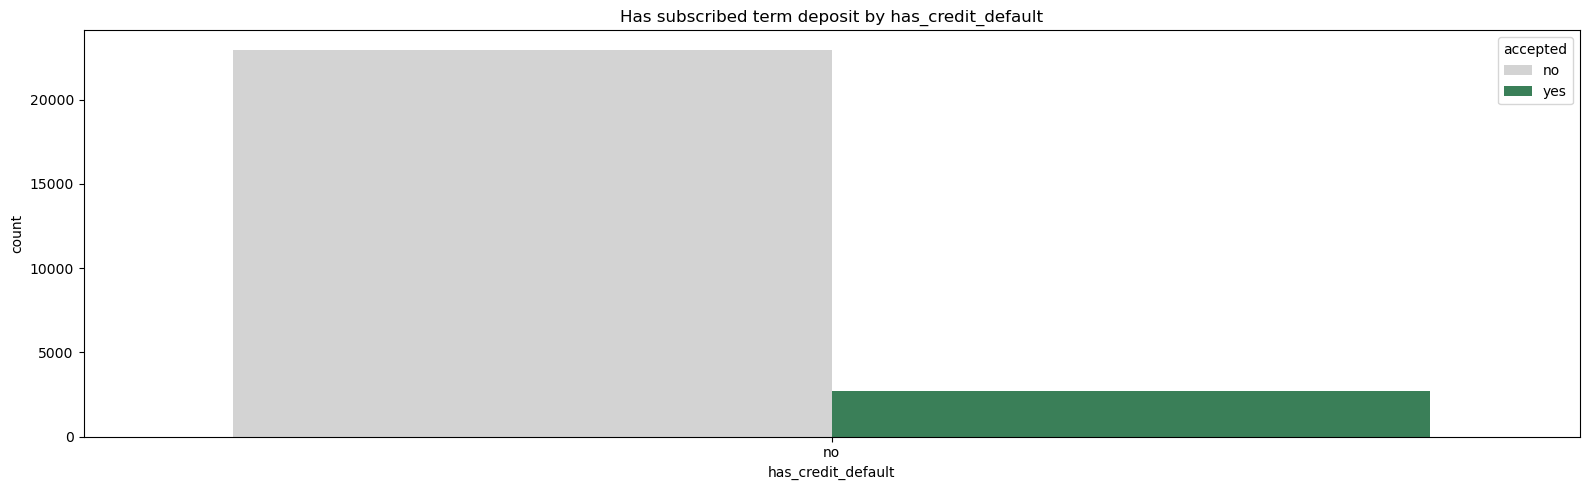

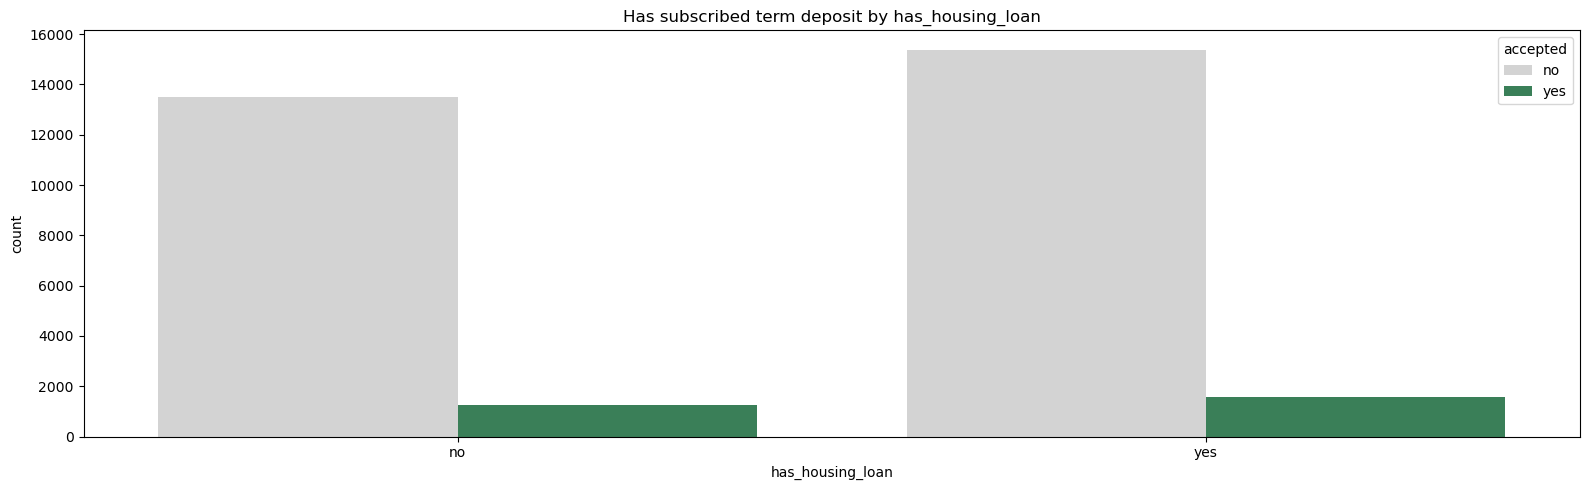

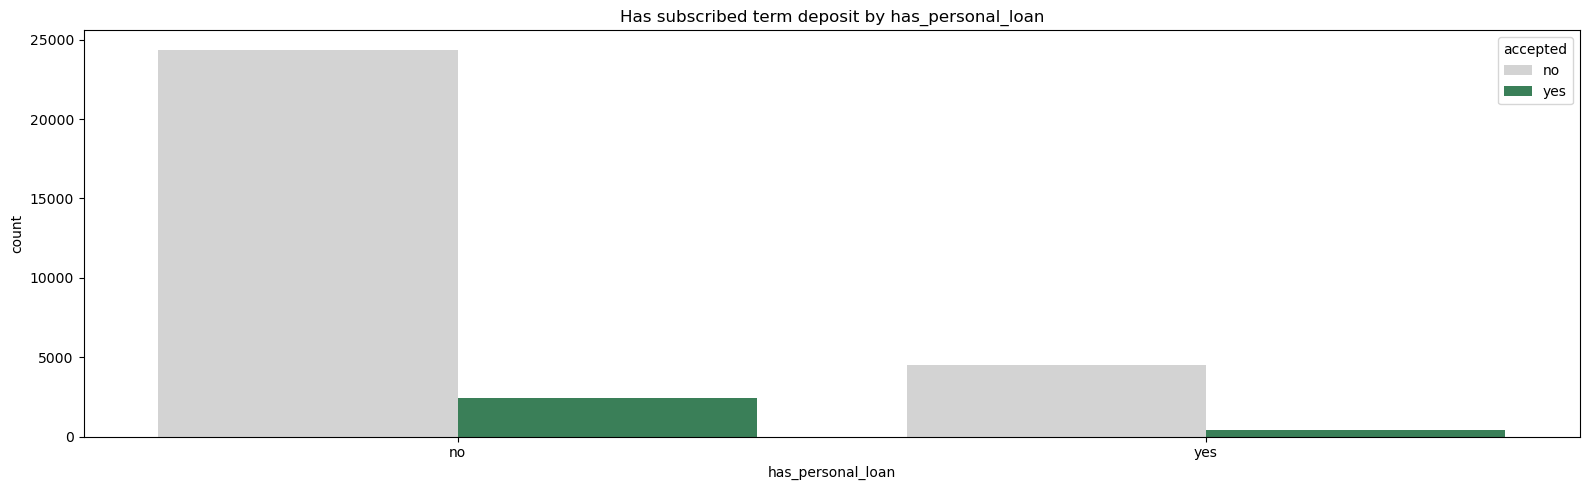

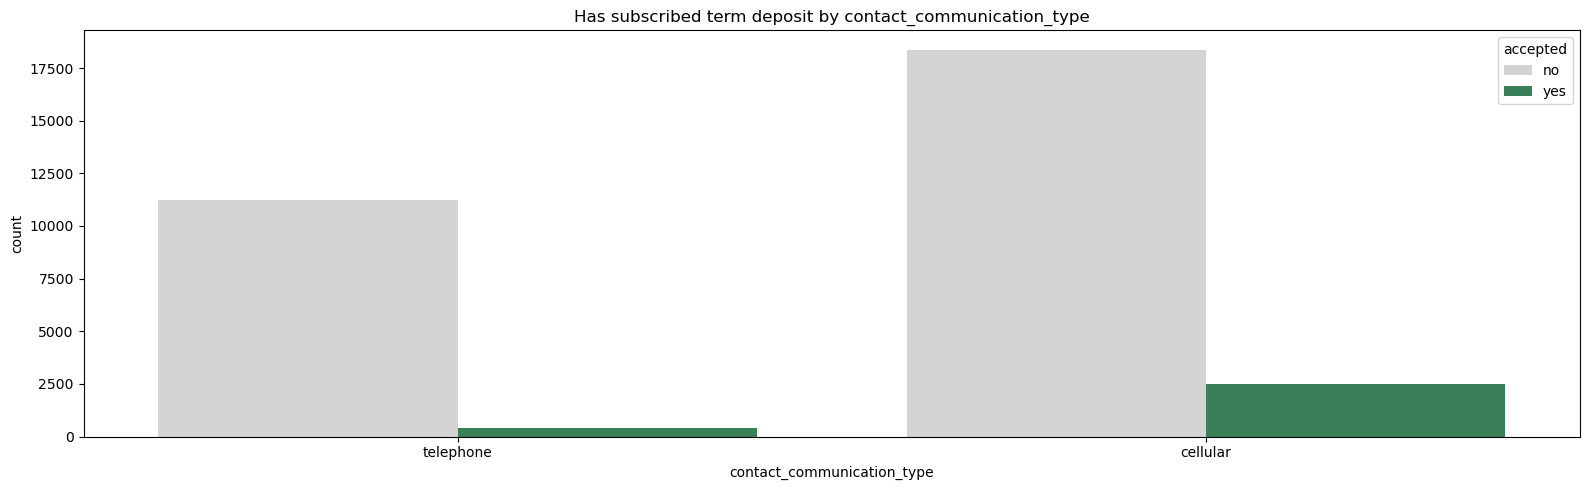

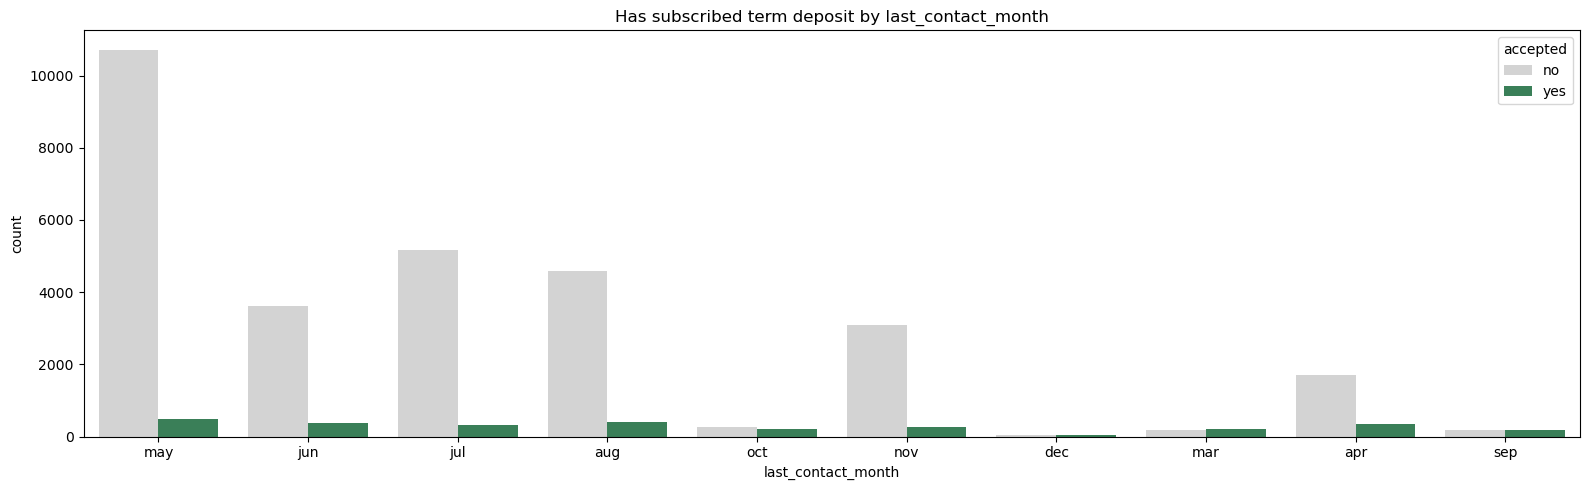

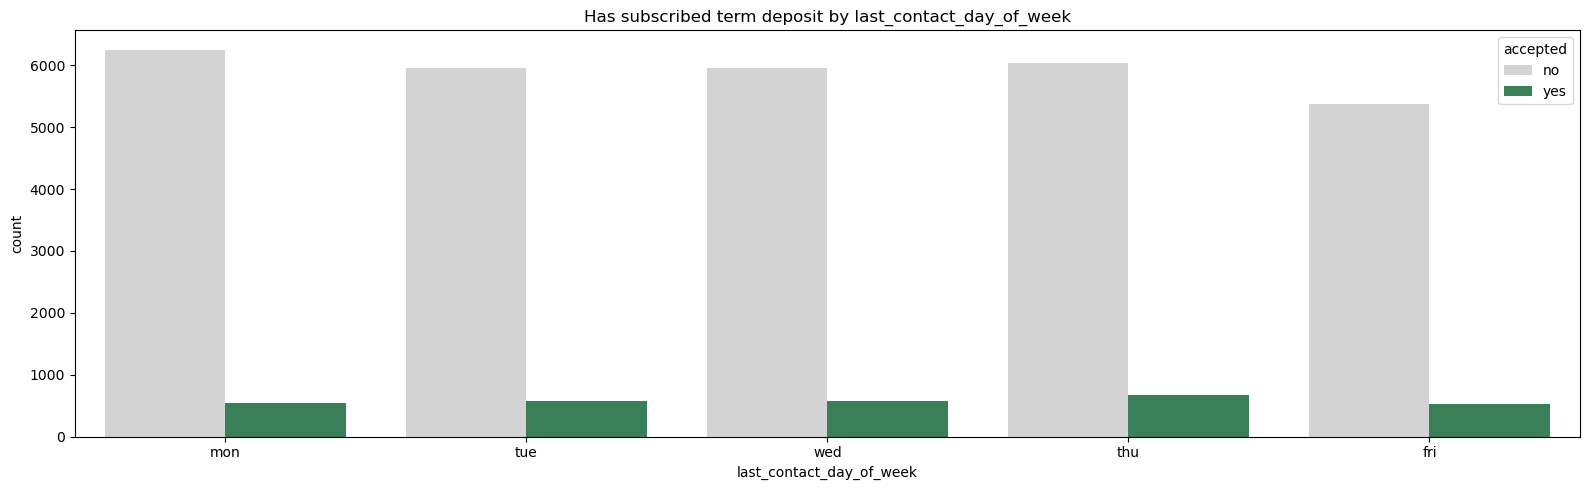

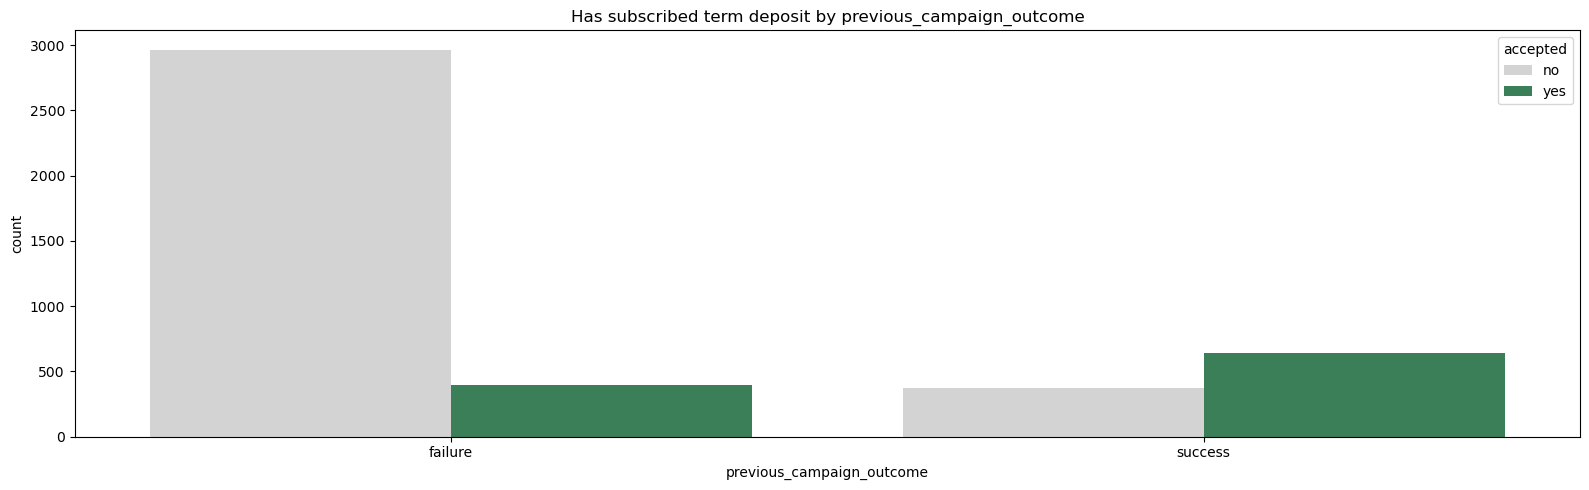

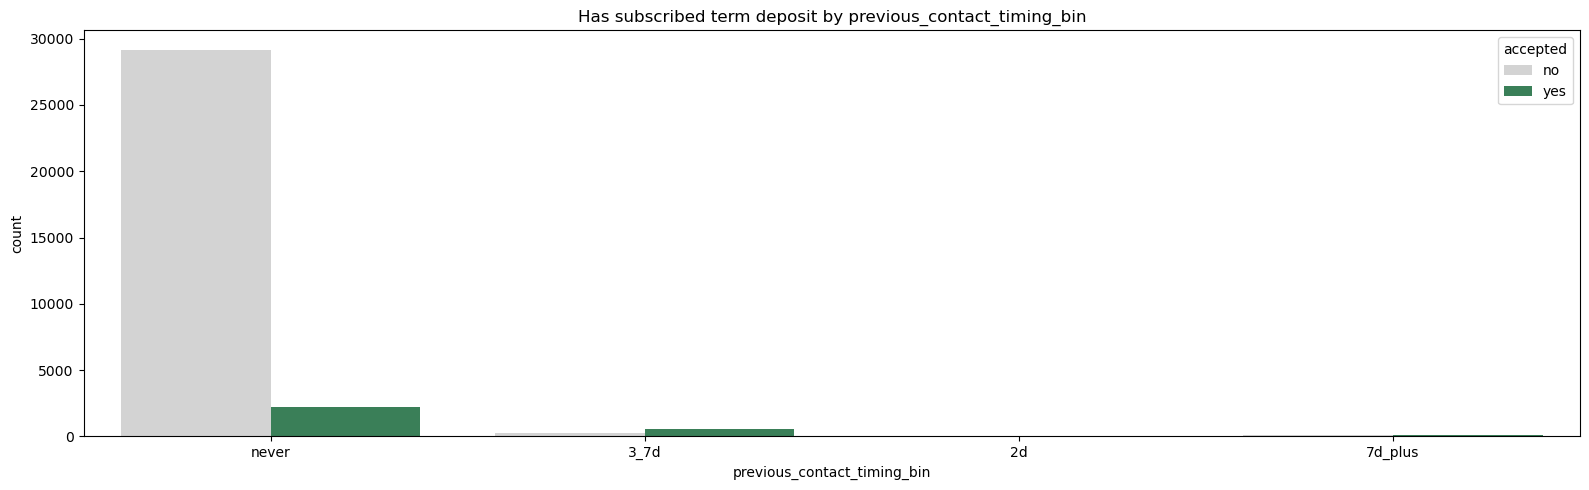

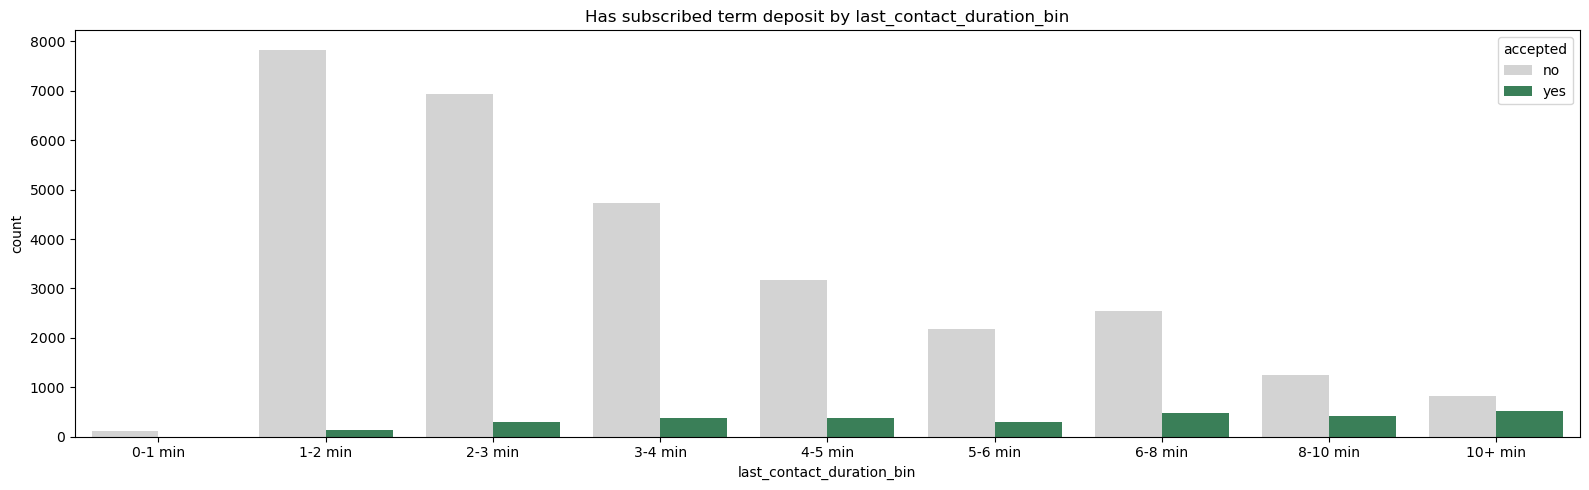

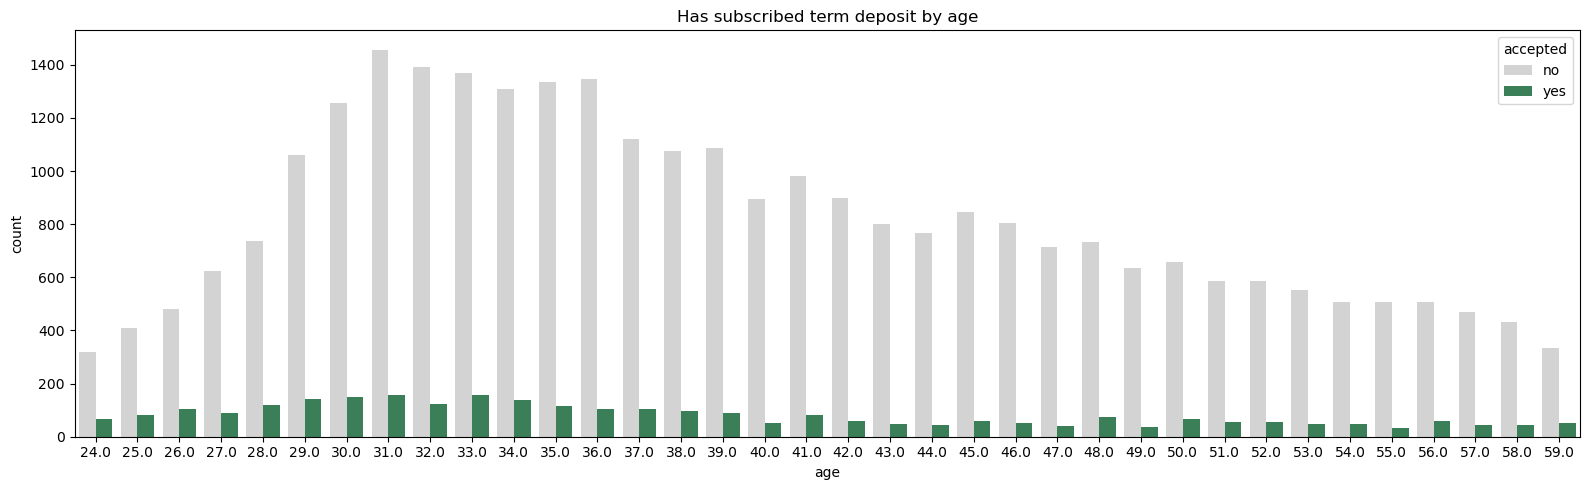

In [19]:
# plot count plots for all categorial columns with hue = has_subscribed_term_deposit
categorial_columns = bankdf.select_dtypes(include=['object', 'category']).columns.tolist()
categorial_columns.append('age')

for column in categorial_columns:
    if column == 'has_subscribed_term_deposit':
        continue

    df = bankdf[[column, 'has_subscribed_term_deposit']].copy()
    df['has_subscribed_term_deposit'] = df['has_subscribed_term_deposit'].replace({1: 'Yes', 0: 'No'})

    # rename for clarity
    df.rename(columns = {
        'has_subscribed_term_deposit': 'accepted'
    }, inplace=True)

    plt.figure(figsize=(16, 5))
    sns.countplot(
        data=df,
        x=column,
        hue="accepted",
        palette={'yes': 'seagreen', 'no': 'lightgray'}
    )

    plt.title(f"Has subscribed term deposit by {column}")
    plt.xlabel(column)

    plt.tight_layout()
    plt.savefig(f'images/intuitive_price_drivers_{column}.png')
    plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective

**Primary Goal:** Develop a machine learning model to predict whether a bank customer will subscribe to a term deposit based on marketing campaign data.

**Specific Objectives:**
1. **Classification Task**: Build binary classifiers to predict subscription likelihood (yes/no)
2. **Model Comparison**: Compare performance of multiple algorithms:
   - K-Nearest Neighbors (KNN)
   - Logistic Regression  
   - Decision Trees
   - Support Vector Machines (SVM)
3. **Performance Optimization**: Identify the best-performing model through hyperparameter tuning
4. **Business Impact**: Enable the bank to:
   - Target high-probability prospects more effectively
   - Optimize marketing resource allocation
   - Improve campaign ROI by focusing on likely subscribers
   - Reduce customer acquisition costs

**Success Metrics**: Model accuracy, precision, recall, and F1-score for subscription prediction.

### Problem 5: Train/Test Split

With your data prepared, split it into a train and test set.

It also seems reasonable to use a constant imputer with value `0` for the `previous_campaign_num_contacts` column based on the missingness statistics, and `'missing'` for the `job_type`, `marital_status`, `education_level`, `has_credit_default	`, `has_housing_loan`, `has_personal_loan` and `previous_campaign_outcome` column.

**Steps:**
1. Separate your features (`X`) and target (`y`).
2. Encode the target variable if needed.
3. Identify categorical and numerical columns.
4. Create a preprocessing pipeline that imputes missing values (`0` for numerical, `'missing'` for categorical).
5. Split the data into training and test sets (e.g., 80/20 split).

In [20]:
from sklearn.impute import SimpleImputer

X = bankdf.drop('has_subscribed_term_deposit', axis=1)
y = bankdf['has_subscribed_term_deposit']

le = LabelEncoder()
y = le.fit_transform(y)

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create preprocessing pipeline with missing value handling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'logisticregression': (LogisticRegression(max_iter=1000), {
        'logisticregression__C': [0.1, 1, 10]
    }), # base line model
    'decisiontreeclassifier': (DecisionTreeClassifier(), {
        'decisiontreeclassifier__max_depth': [3, 4, 5, 10, 15, 20]
    }),
    'knn': (KNeighborsClassifier(), {
        'knn__n_neighbors': [3, 5, 7]
    }),
    'svc': (SVC(), {
        'svc__C': [0.1, 1],
        'svc__kernel': ['linear', 'rbf'],
        'svc__class_weight': ['balanced'],      # Important for imbalanced data
        'svc__probability': [True]              # Needed for ROC curves
     })
}

# use stratified sampling to ensure proportion of each class is same in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

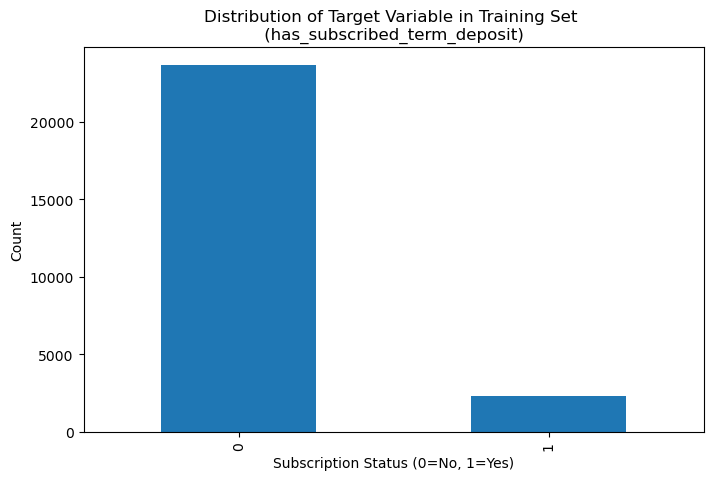

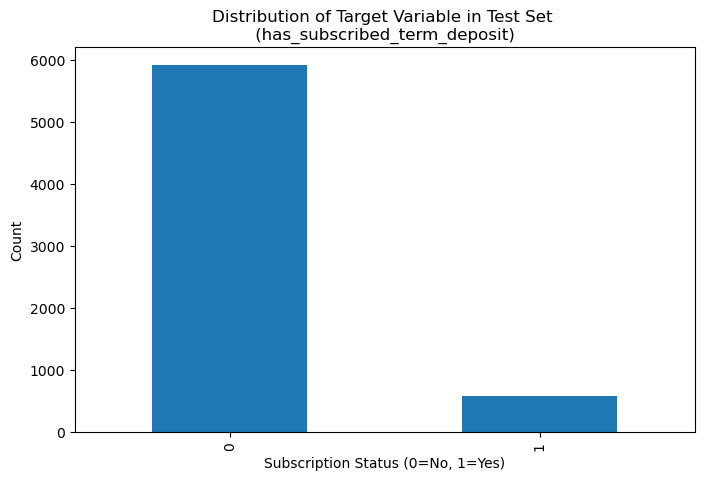

In [21]:
# Distribution of Target Variable in Training Set
plt.figure(figsize=(8, 5))
pd.Series(y_train, name='has_subscribed_term_deposit').value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable in Training Set \n (has_subscribed_term_deposit) ')
plt.xlabel('Subscription Status (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

# Distribution of Target Variable in Test Set
plt.figure(figsize=(8, 5))
pd.Series(y_test, name='has_subscribed_term_deposit').value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable in Test Set \n (has_subscribed_term_deposit) ')
plt.xlabel('Subscription Status (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

### Problem 7: Model

We will create the following models using Logistic Regression as the baseline model to compare with more sophisticated algorithms:

- **Logistic Regression** (baseline)
- **K-Nearest Neighbors (KNN)**
- **Decision Trees**
- **Support Vector Machines (SVM)**

#### Performance Metric: F1 Score

We will use **F1 score** as our primary metric to select the best model, as it is ideal for our bank marketing use case where we need to balance both precision and recall:

**Why F1 Score is Optimal for Bank Marketing:**

- **High Precision**: Avoid wasting marketing budget on unlikely prospects
  - Reduces cost of contacting non-interested customers
  - Minimizes customer annoyance from irrelevant marketing calls

- **High Recall**: Don't miss potential subscribers  
  - Captures maximum number of actual prospects
  - Maximizes revenue opportunities from interested customers

- **F1 Score**: Ensures optimization for both efficiency and coverage
  - Harmonic mean of precision and recall
  - Penalizes models that sacrifice one metric for the other
  - Provides balanced performance assessment

**Business Impact:**
This approach ensures our model identifies genuine prospects while maintaining cost-effective marketing operations, ultimately maximizing both customer satisfaction.


=== Training LOGISTICREGRESSION ===
Best parameters for logisticregression: {'logisticregression__C': 0.1}
AUC-ROC Score: 0.8329
F1 Optimal Threshold: 0.200 (F1: 0.512)


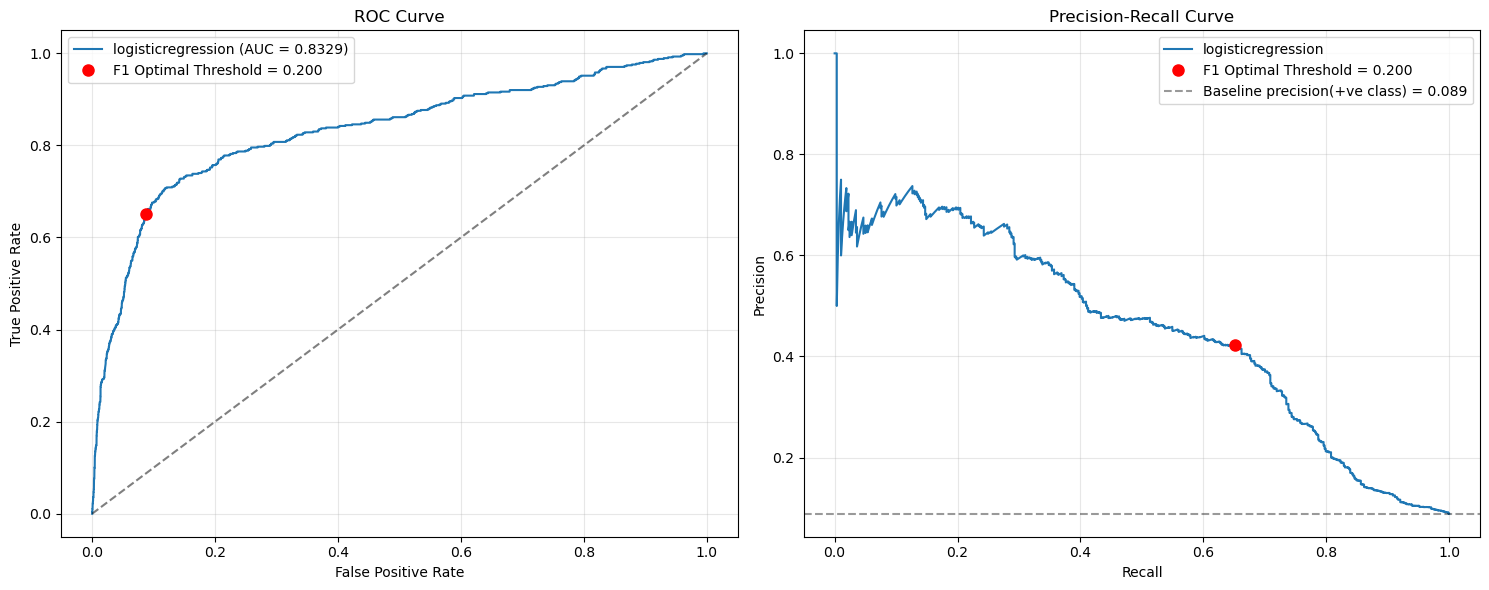

Confusion Matrix for logisticregression (F1 threshold=0.200):
[[5403  515]
 [ 201  376]]
Test Metrics (F1 optimized):
  Accuracy: 0.890
  Precision: 0.422
  Recall: 0.652
  F1 Score: 0.512

=== Training DECISIONTREECLASSIFIER ===
Best parameters for decisiontreeclassifier: {'decisiontreeclassifier__max_depth': 5}
AUC-ROC Score: 0.8274
F1 Optimal Threshold: 0.167 (F1: 0.497)


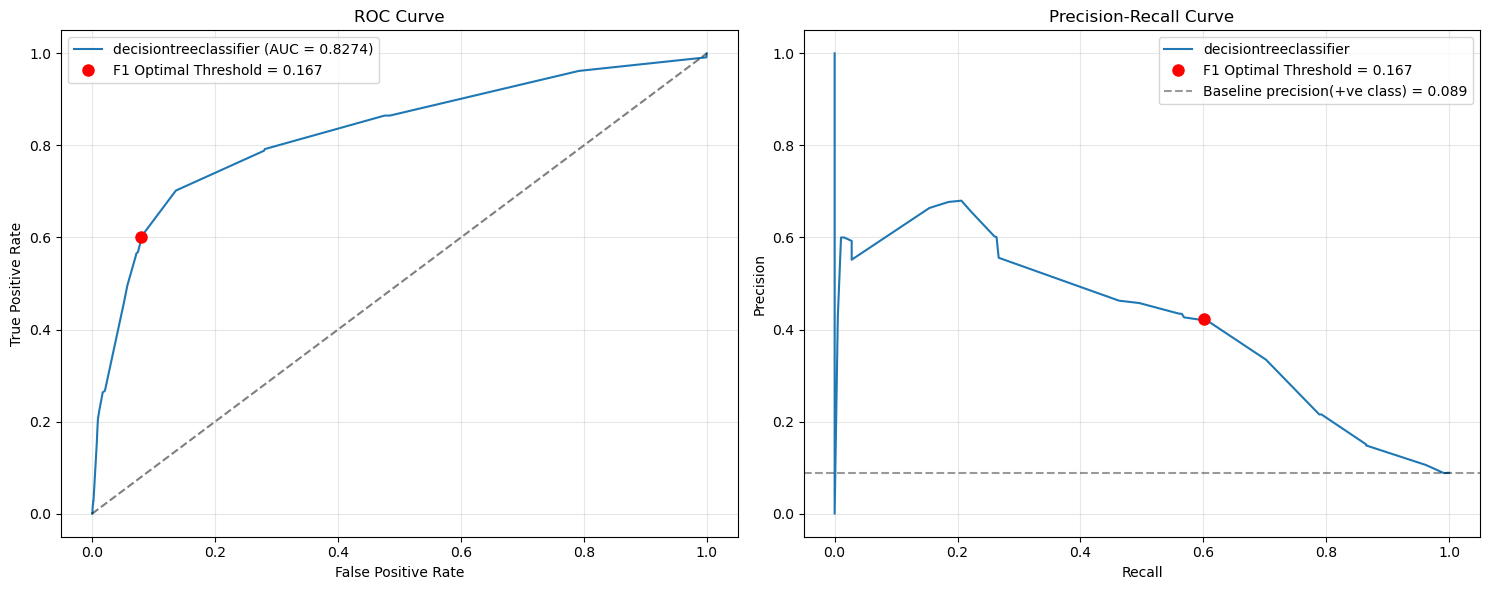

Confusion Matrix for decisiontreeclassifier (F1 threshold=0.167):
[[5446  472]
 [ 230  347]]
Test Metrics (F1 optimized):
  Accuracy: 0.892
  Precision: 0.424
  Recall: 0.601
  F1 Score: 0.497

=== Training KNN ===
Best parameters for knn: {'knn__n_neighbors': 7}
AUC-ROC Score: 0.7843
F1 Optimal Threshold: 0.286 (F1: 0.473)


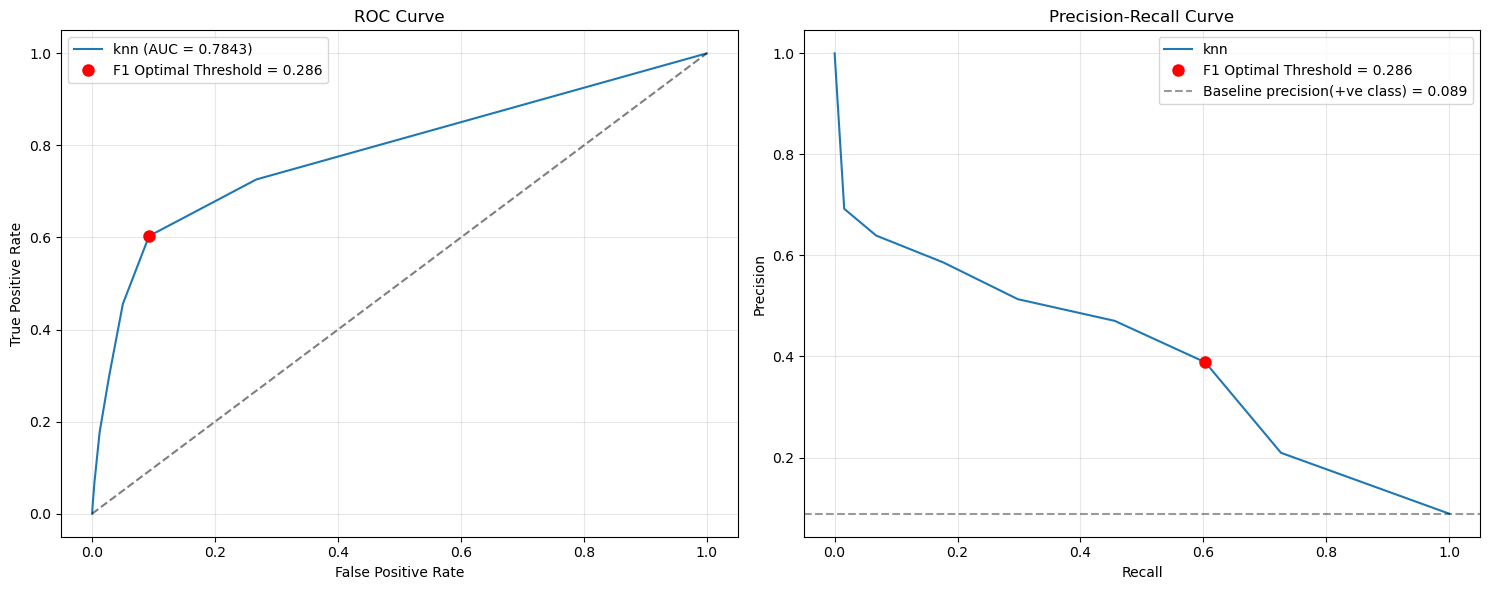

Confusion Matrix for knn (F1 threshold=0.286):
[[5370  548]
 [ 229  348]]
Test Metrics (F1 optimized):
  Accuracy: 0.880
  Precision: 0.388
  Recall: 0.603
  F1 Score: 0.473

=== Training SVC ===
Best parameters for svc: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf', 'svc__probability': True}
AUC-ROC Score: 0.8263
F1 Optimal Threshold: 0.335 (F1: 0.503)


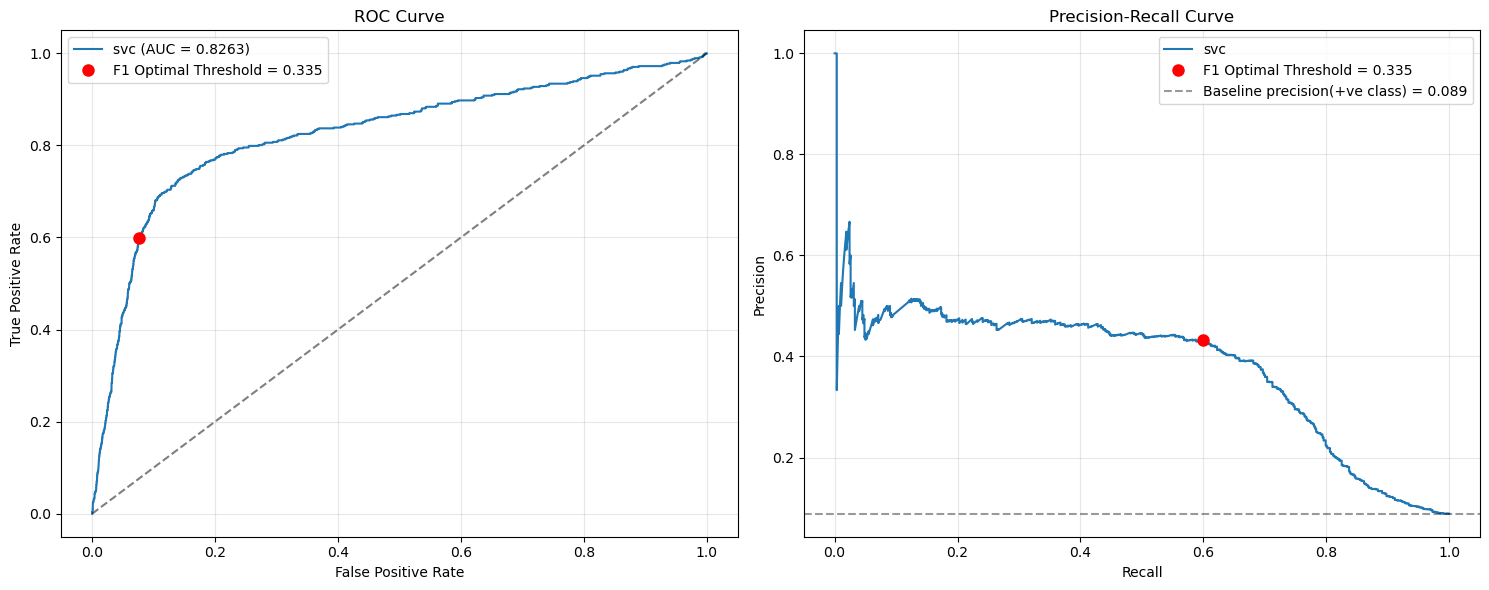

Confusion Matrix for svc (F1 threshold=0.335):
[[5464  454]
 [ 231  346]]
Test Metrics (F1 optimized):
  Accuracy: 0.895
  Precision: 0.432
  Recall: 0.600
  F1 Score: 0.503

=== MODEL COMPARISON RESULTS (F1 OPTIMIZED) ===


,model,train_score,test_score,test_accuracy,test_precision,test_recall,test_f1,optimal_threshold,auc_roc,train_time,test_time
0,logisticregression,0.923207,0.923018,0.889761,0.421998,0.651646,0.512262,0.200282,0.832900,4.291632,0.0
1,decisiontreeclassifier,0.923900,0.920554,0.891917,0.423687,0.601386,0.497135,0.166667,0.827442,2.741702,0.0
2,knn,0.931599,0.912548,0.880370,0.388393,0.603120,0.472505,0.285714,0.784325,205.351540,0.0
3,svc,0.866816,0.844496,0.894534,0.432500,0.599653,0.502542,0.334966,0.826289,1348.073337,0.0


In [22]:
# F1 = 2 × (Precision × Recall) / (Precision + Recall)
def find_optimal_threshold_f1(model, X, y):
    """
    Finds the optimal classification threshold that maximizes the F1-score.
    
    Args:
        model: A trained scikit-learn model with a predict_proba method.
        X: The feature data (e.g., X_test).
        y: The true labels (e.g., y_test).
        
    Returns:
        A tuple containing the optimal threshold and the maximum F1-score.
    """
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    max_f1 = f1_scores[optimal_idx]
    
    return optimal_threshold, max_f1


def plot_evaluation_curves(name, y_test, y_pred_proba, f1_threshold, roc_auc):
    """
    Generates and displays ROC and Precision-Recall curves.
    
    Args:
        name: The name of the model.
        y_test: The true labels.
        y_pred_proba: The predicted probabilities for the positive class.
        f1_threshold: The optimal F1 threshold to plot on the curves.
        roc_auc: The AUC-ROC score.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Index of point closest to F1 threshold on each curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    roc_threshold_idx = np.argmin(np.abs(roc_thresholds - f1_threshold))

    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_threshold_idx = np.argmin(np.abs(pr_thresholds - f1_threshold))
    baseline = y_test.mean()

    # ROC Curve
    ax1.plot(
        fpr, 
        tpr, 
        label=f'{name} (AUC = {roc_auc:.4f})'
    )
    ax1.plot(
        fpr[roc_threshold_idx], 
        tpr[roc_threshold_idx], 
        'ro', 
        markersize=8, 
        label=f'F1 Optimal Threshold = {f1_threshold:.3f}'
    )
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax2.plot(
        recall, 
        precision, 
        label=f'{name}'
    )
    ax2.plot(
        recall[pr_threshold_idx], 
        precision[pr_threshold_idx],
        'ro', 
        markersize=8, 
        label=f'F1 Optimal Threshold = {f1_threshold:.3f}'
    )
    ax2.axhline(
        baseline,
        color="k",
        linestyle="--",
        alpha=0.4,
        label=f"Baseline precision(+ve class) = {baseline:.3f}",
    )
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(name, model, params, preprocessor, X_train, y_train, X_test, y_test):
    """
    Trains a model within a pipeline, performs a grid search, and evaluates it.
    
    Args:
        name: The name of the model.
        model: The scikit-learn estimator object.
        params: The parameter grid for grid search.
        preprocessor: The data preprocessor object.
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        
    Returns:
        A dictionary of evaluation results for the model.
    """
    print(f"\n=== Training {name.upper()} ===")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    y_pred_proba = None
    roc_auc = 0
    # avg_precision = 0
    optimal_threshold = 0.5
    
    if hasattr(best_model, 'predict_proba'):
        # take the predicted probabilities for the positive class
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # avg_precision = average_precision_score(y_test, y_pred_proba)
        
        print(f"AUC-ROC Score: {roc_auc:.4f}")
        # print(f"Average Precision Score: {avg_precision:.4f}")
        
        f1_threshold, max_f1 = find_optimal_threshold_f1(best_model, X_test, y_test)
        optimal_threshold = f1_threshold
        print(f"F1 Optimal Threshold: {f1_threshold:.3f} (F1: {max_f1:.3f})")
        
        plot_evaluation_curves(name, y_test, y_pred_proba, optimal_threshold, roc_auc)
    else:
        print("AUC-ROC Score and curves not plotted due to missing predict_proba")

    start_time = time.time()
    if y_pred_proba is not None:
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    else:
        y_pred = best_model.predict(X_test)
    test_time = time.time() - start_time
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name} (F1 threshold={optimal_threshold:.3f}):\n{conf_matrix}")
    
    test_accuracy = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"Test Metrics (F1 optimized):")
    print(f"  Accuracy: {test_accuracy:.3f}")
    print(f"  Precision: {test_precision:.3f}")
    print(f"  Recall: {test_recall:.3f}")
    print(f"  F1 Score: {test_f1:.3f}")
    
    return {
        'model': name,
        'train_score': train_score,
        'test_score': test_score,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'optimal_threshold': optimal_threshold,
        'auc_roc': roc_auc,
        'train_time': train_time,
        'test_time': test_time,
        'grid_search': grid_search
    }

def run_all_models(models, preprocessor, X_train, y_train, X_test, y_test):
    """
    Main function to run the training and evaluation loop for all models.
    
    Args:
        models: A dictionary of models and their parameter grids.
        preprocessor: The data preprocessor object.
        X_train, y_train, X_test, y_test: The data splits.
        
    Returns:
        A pandas DataFrame with the results for all models.
    """
    results = []
    for name, (model, params) in models.items():
        result = train_and_evaluate_model(name, model, params, preprocessor, X_train, y_train, X_test, y_test)
        results.append(result)
        
    return pd.DataFrame(results)

comparison_df = run_all_models(models, preprocessor, X_train, y_train, X_test, y_test)
print("\n=== MODEL COMPARISON RESULTS (F1 OPTIMIZED) ===")
display(comparison_df.drop(columns=['grid_search']))


=== FEATURE IMPORTANCE RANKING ===
--------------------------------------------------
Model logisticregression - Top 28 Features:


,feature,importance
0,num__employment_variation_rate,-1.569042
1,cat__last_contact_month_mar,1.282870
2,cat__previous_contact_timing_bin_never,-0.761931
3,cat__previous_campaign_outcome_success,0.751039
4,num__consumer_price_index,0.730400
5,cat__previous_contact_timing_bin_3_7d,0.551824
6,cat__last_contact_month_may,-0.543410
7,cat__last_contact_month_aug,0.501436
8,cat__has_credit_default_no,0.395099
9,cat__last_contact_month_oct,0.393344


--------------------------------------------------


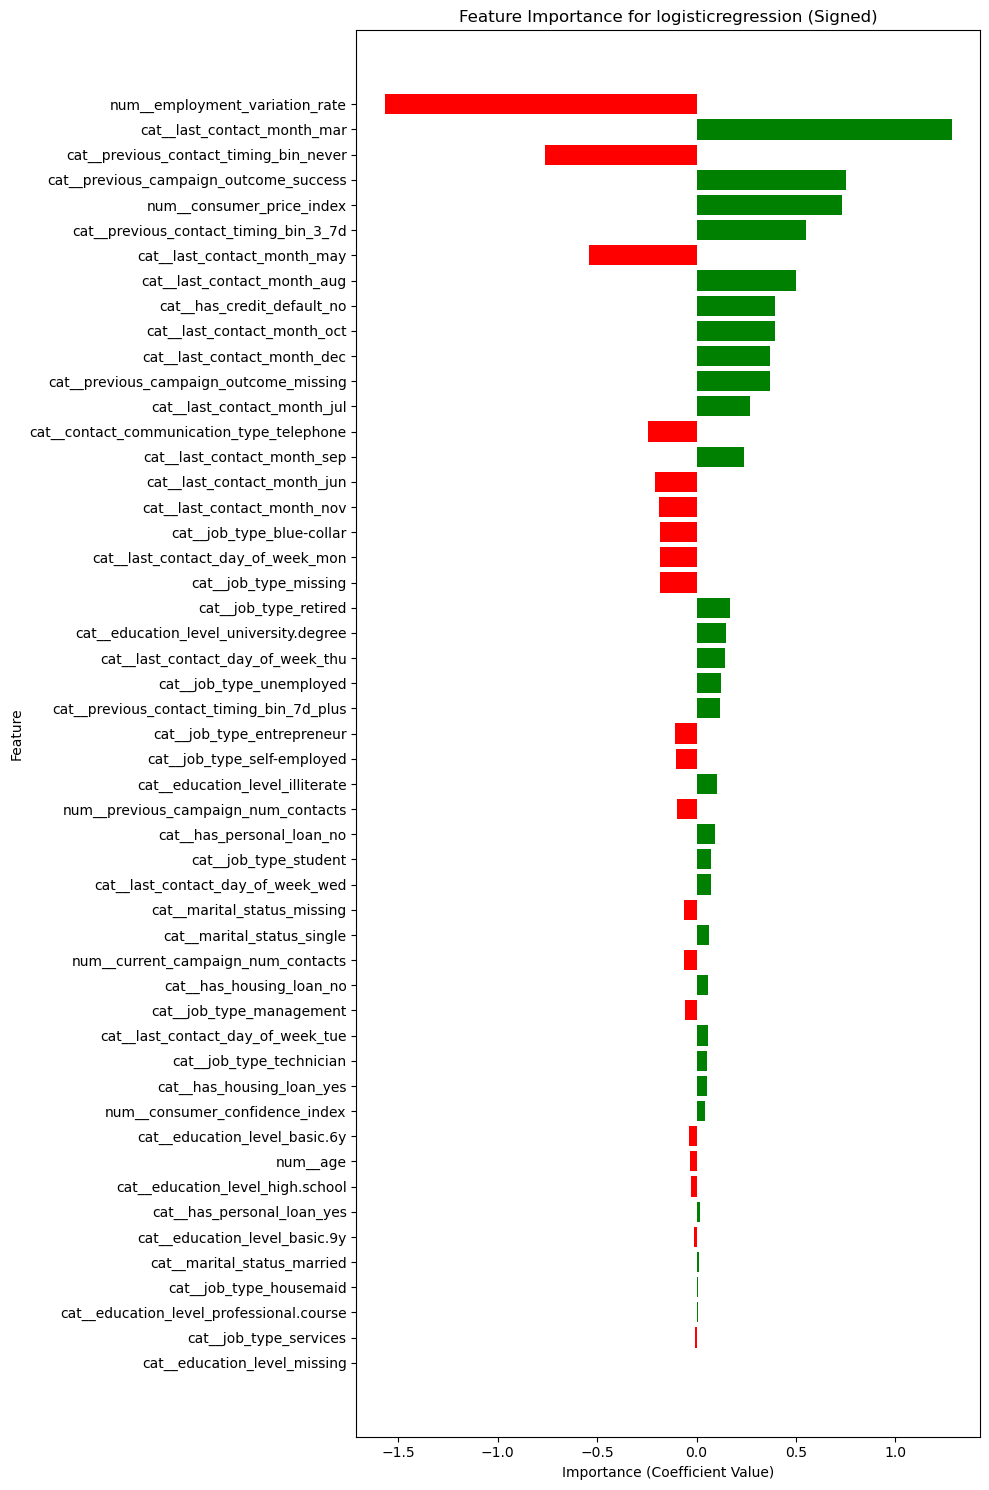

--------------------------------------------------
Model decisiontreeclassifier - Top 19 Features:


,feature,importance
0,cat__previous_contact_timing_bin_never,0.437577
1,num__consumer_confidence_index,0.243544
2,num__employment_variation_rate,0.203219
3,cat__last_contact_month_oct,0.046677
4,cat__previous_campaign_outcome_missing,0.011015
5,cat__last_contact_month_may,0.009554
6,num__consumer_price_index,0.008498
7,cat__previous_campaign_outcome_success,0.005741
8,num__age,0.004503
9,cat__previous_contact_timing_bin_3_7d,0.004094


--------------------------------------------------


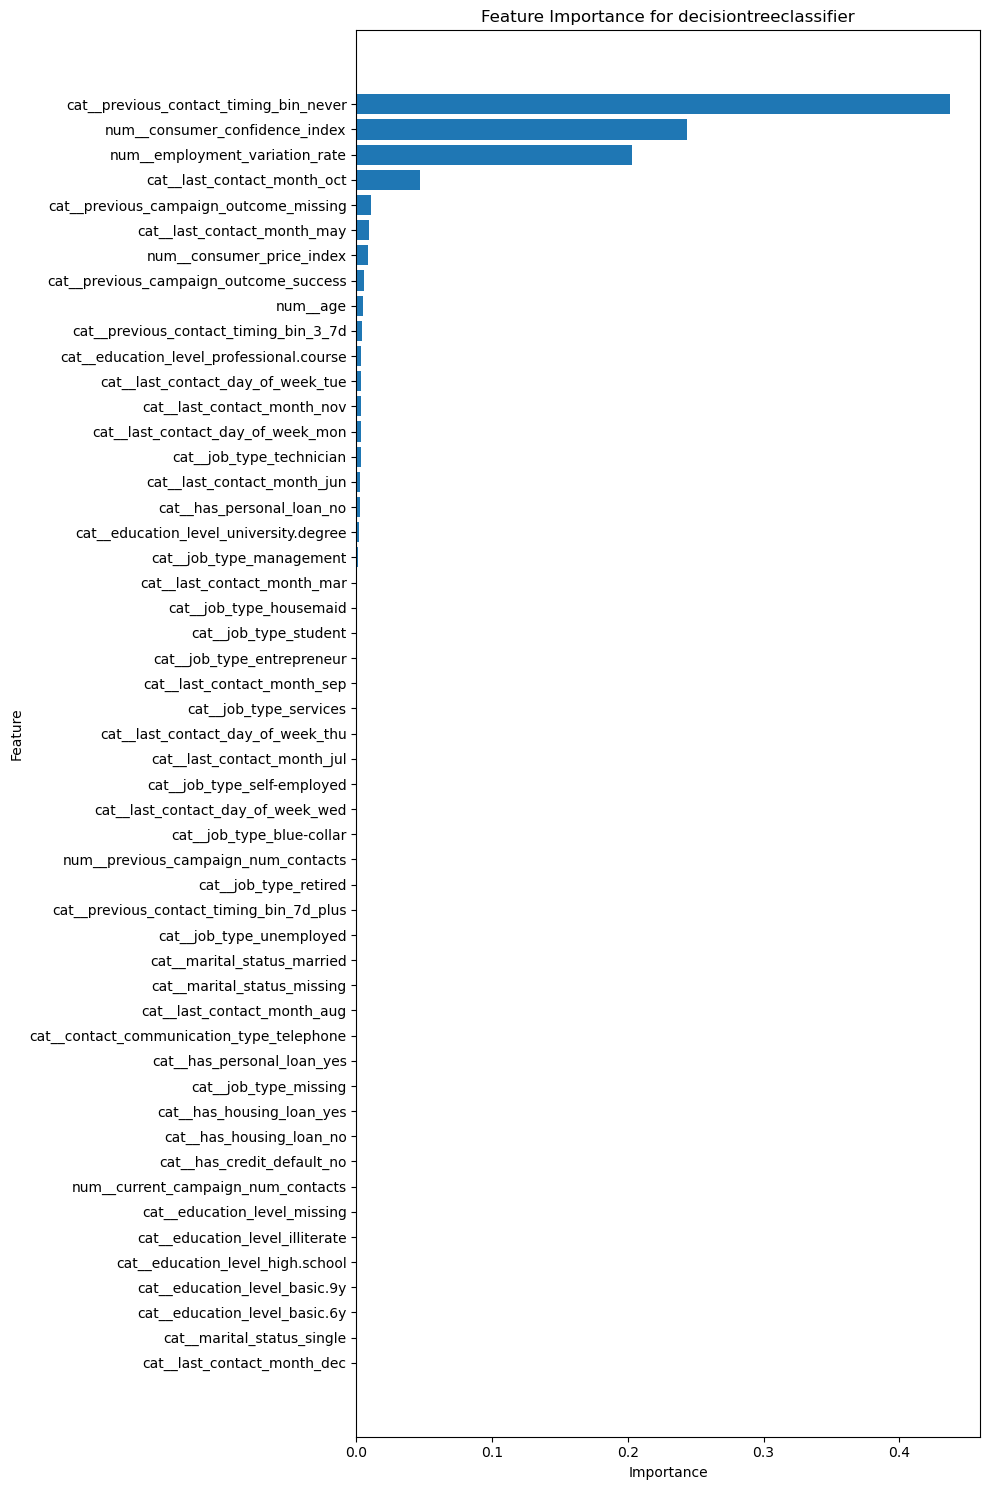

--------------------------------------------------
Model knn - Top 48 Features:


,feature,importance
0,num__employment_variation_rate,0.134513
1,cat__previous_campaign_outcome_success,0.057881
2,num__previous_campaign_num_contacts,0.054988
3,cat__previous_contact_timing_bin_never,0.045094
4,num__consumer_confidence_index,0.041949
5,cat__previous_contact_timing_bin_3_7d,0.024242
6,num__consumer_price_index,0.017591
7,cat__contact_communication_type_telephone,0.012736
8,cat__job_type_management,0.009637
9,cat__last_contact_month_sep,0.008759


--------------------------------------------------


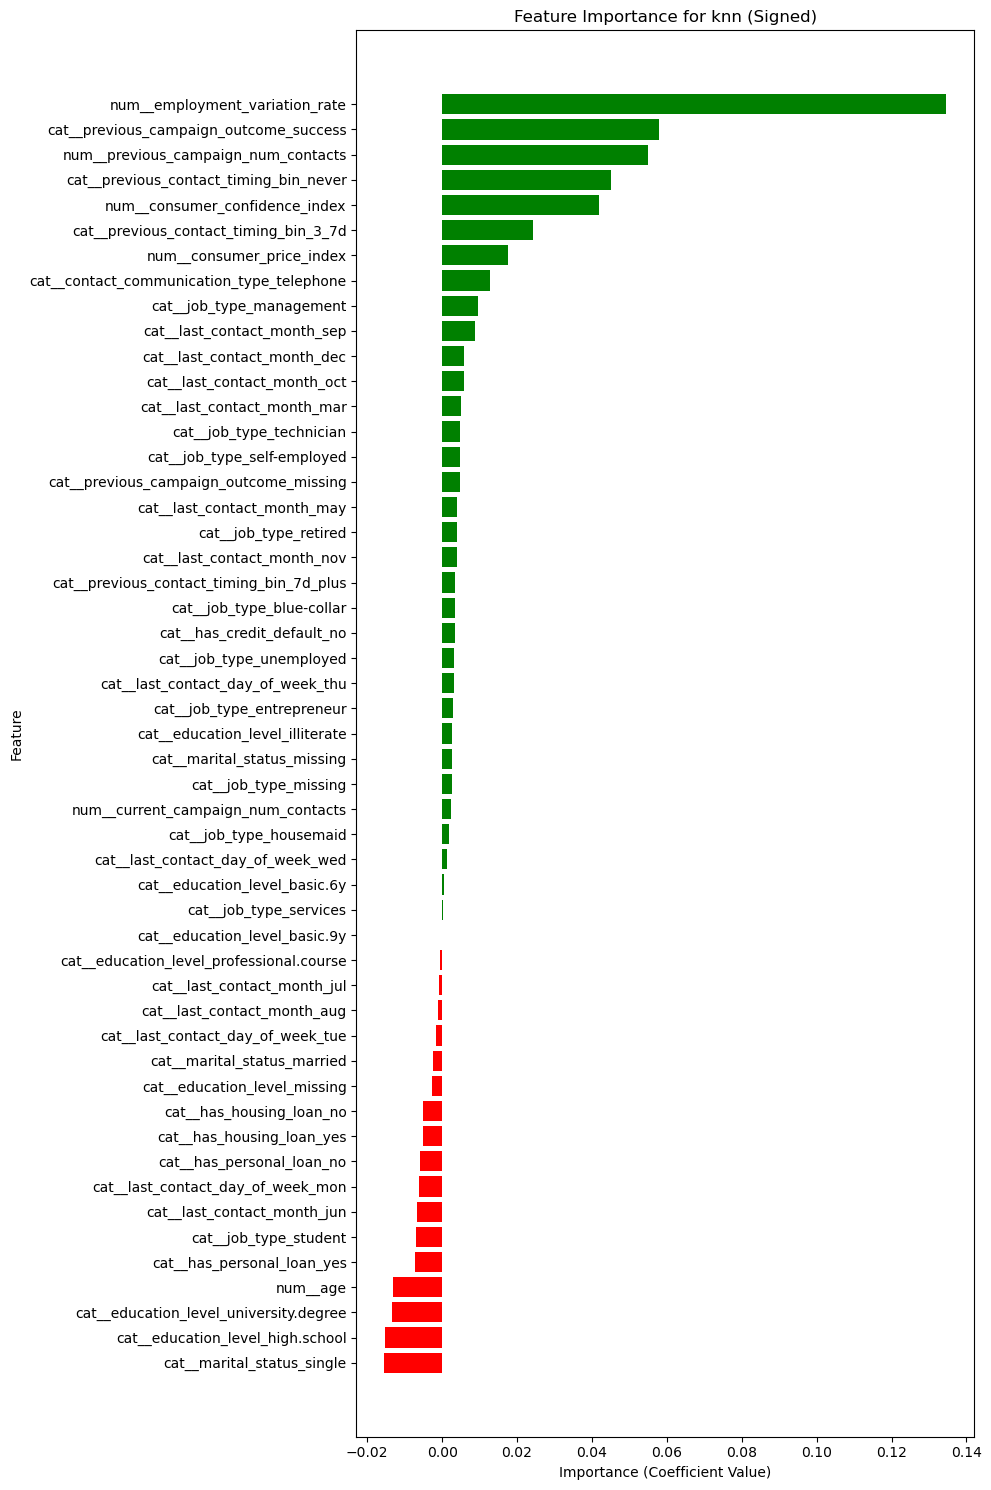

--------------------------------------------------
Model svc - Top 49 Features:


,feature,importance
0,num__employment_variation_rate,0.253468
1,num__consumer_price_index,0.066759
2,num__consumer_confidence_index,0.057361
3,cat__last_contact_month_may,0.017110
4,num__previous_campaign_num_contacts,0.012239
5,cat__contact_communication_type_telephone,0.005781
6,cat__education_level_high.school,0.005438
7,num__current_campaign_num_contacts,0.004601
8,num__age,0.004409
9,cat__last_contact_day_of_week_thu,0.003008


--------------------------------------------------


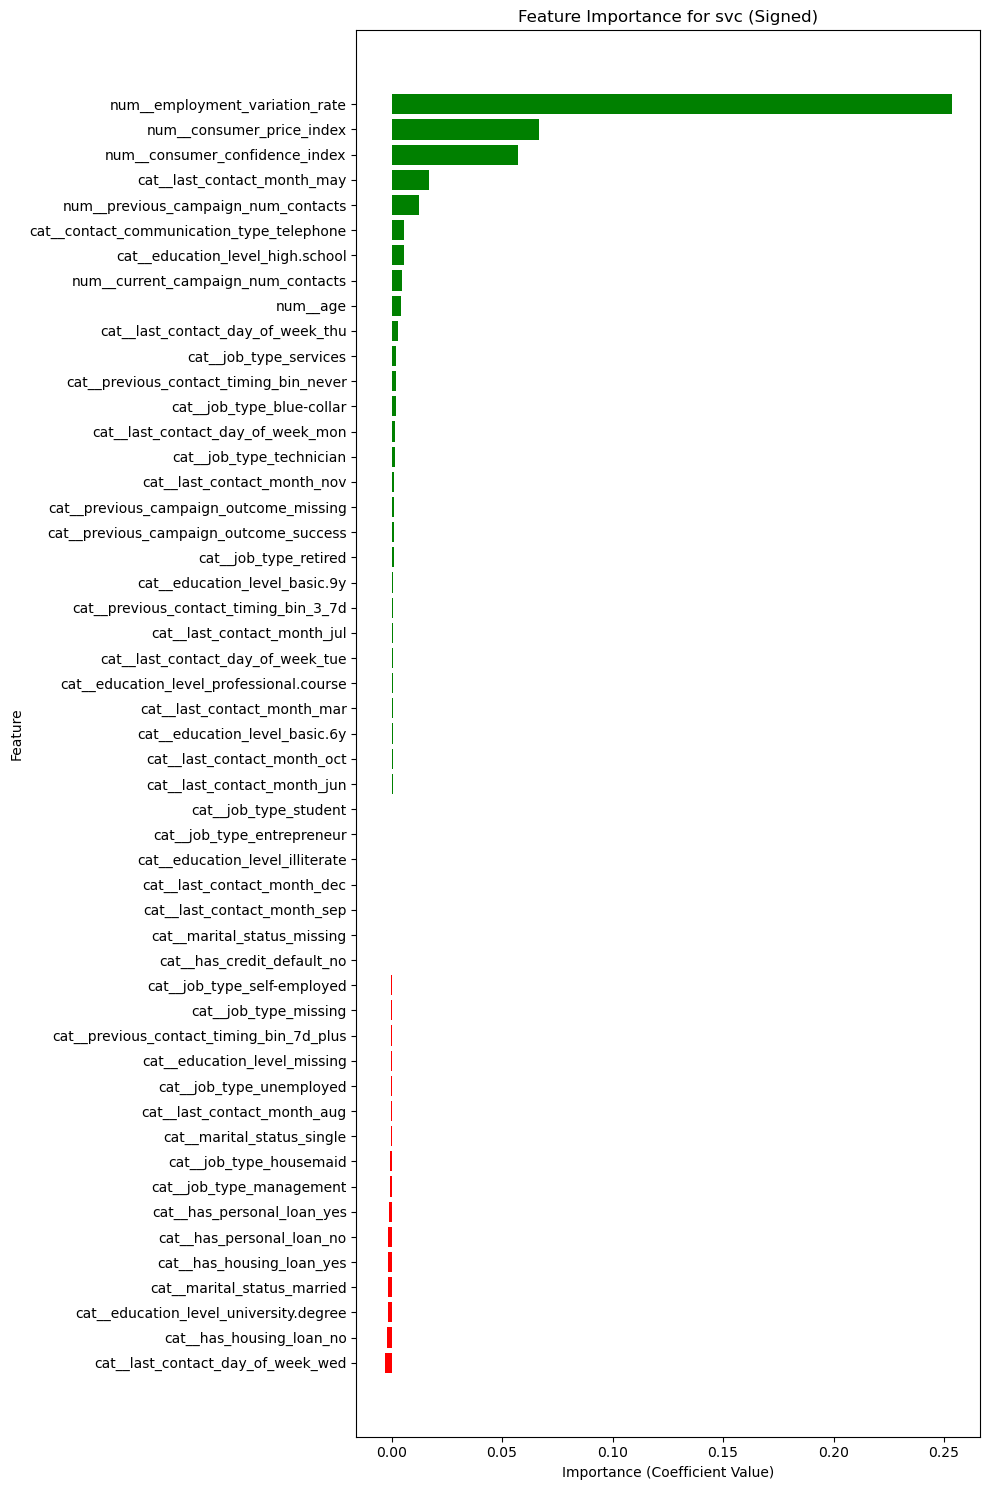

In [23]:
def get_feature_names_safe(pipeline):
    """Extract feature names from pipeline preprocessor"""
    try:
        return pipeline.named_steps['preprocessor'].get_feature_names_out()
    except Exception as e:
        print(f"Error getting feature names: {e}")
        return None

def create_importance_dataframe(pipeline, model, feature_names):
    """Create importance DataFrame based on model type."""
    if hasattr(model, 'coef_'):
        # Linear models
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.coef_[0]
        })
        importance_df['abs_importance'] = importance_df['importance'].abs()
        return importance_df.sort_values(by='abs_importance', ascending=False).drop(columns='abs_importance')
    
    elif hasattr(model, 'feature_importances_'):
        # Tree-based models
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        })
        return importance_df.sort_values(by='importance', ascending=False)
    
    else: 
        # For models without direct importance attributes (like KNN or SVC)
        # Use permutation importance on transformed features
        preprocessor = pipeline.named_steps['preprocessor']
        X_test_transformed = preprocessor.transform(X_test)
        
        # Convert sparse matrix to dense array if needed
        if hasattr(X_test_transformed, 'toarray'):
            X_test_transformed = X_test_transformed.toarray()
        
        # Get transformed feature names
        transformed_feature_names = preprocessor.get_feature_names_out()
        
        # Use permutation importance on the individual model with transformed data
        result = permutation_importance(model, X_test_transformed, y_test, n_repeats=3, random_state=42, scoring='f1', n_jobs=-1)
        
        importance_df = pd.DataFrame({
            'feature': transformed_feature_names,
            'importance': result.importances_mean
        })
        return importance_df.sort_values(by='importance', ascending=False)
    

def plot_feature_importance(importance_df, model_name, top_n):
    """Plot feature importance with appropriate colors."""
    top_features = importance_df.head(top_n)
    
    # Check if values can be negative (linear models)
    has_negative = (top_features['importance'] < 0).any()
    colors = ['green' if x > 0 else 'red' for x in top_features['importance']] if has_negative else None
    
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.barh(top_features['feature'], top_features['importance'], color=colors)
    ax.set_xlabel('Importance (Coefficient Value)' if has_negative else 'Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Feature Importance for {model_name}' + (' (Signed)' if has_negative else ''))
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def analyze_feature_importance(comparison_df):
    """Analyze feature importance for all models in comparison_df."""
    print("\n=== FEATURE IMPORTANCE RANKING ===")
    
    for idx, row in comparison_df.iterrows():
        model_name = row["model"]
        best_pipeline = row["grid_search"].best_estimator_

        if best_pipeline is None or not hasattr(best_pipeline, 'named_steps'):
            print(f"Model {model_name}: Best pipeline not found.")
            continue
        
        print("-" * 50)

        # Get fitted model first
        fitted_model = best_pipeline.named_steps[model_name]
        
        # Always try to get transformed feature names first
        feature_names = get_feature_names_safe(best_pipeline)
        if feature_names is None:
            print(f"Model {model_name}: Could not get feature names")
            continue
        
        # Create importance DataFrame
        importance_df = create_importance_dataframe(best_pipeline, fitted_model, feature_names)
        
        if importance_df is None:
            print(f"Model {model_name}: Unable to calculate feature importance.")
            print("-" * 50)
            continue
        
        # Display results
        threshold = 0.0005 if model_name == 'knn' else (0.1 if hasattr(fitted_model, 'coef_') else 0)
        top_df = importance_df[importance_df['importance'].abs() > threshold].reset_index(drop=True)
        top = len(top_df)
        print(f"Model {model_name} - Top {top} Features:")
        display(top_df)
        print("-" * 50)
        
        # Plot importance - limit to top 20 for readability
        plot_feature_importance(importance_df, model_name, len(importance_df))

# Usage
analyze_feature_importance(comparison_df)

### Problem 8: Model Comparisons

This is a consolidated evaluation of four classifiers (Logistic Regression, Decision Tree, KNN, SVC) trained with identical preprocessing. The primary selection metric is the **F1 score** at an optimized threshold for each model.

#### Overview & Class Balance

The positive class prevalence (subscription = 1) is approximately 8.9% (the baseline precision). A stratified split was used to preserve this distribution.

#### Best Hyperparameters

* **Logistic Regression**: C = 0.1

* **Decision Tree**: max_depth = 5

* **KNN**: n_neighbors = 7

* **SVC**: C = 1, kernel = rbf, class_weight = balanced, probability = True

#### Threshold-Optimized Test Performance

| Model | AUC (ROC) | Threshold | Accuracy | Precision | Recall | F1 Score |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: |
| Logistic Regression | 0.8329 | 0.200 | 0.890 | 0.422 | 0.652 | 0.512 |
| Decision Tree | 0.8292 | 0.167 | 0.892 | 0.424 | 0.603 | 0.498 |
| KNN | 0.7843 | 0.286 | 0.880 | 0.388 | 0.603 | 0.473 |
| SVC | 0.8263 | 0.337 | 0.895 | 0.432 | 0.600 | 0.503 |

**Key points:**

* **Logistic Regression** has the highest F1 score (0.512) and recall (0.652) - best overall performance.

* **SVC** has the highest precision (0.432) and accuracy (0.895) but lower F1 score.

* **Decision Tree** is second-best with balanced performance across metrics.

* **KNN** is the weakest overall with lowest F1 score and AUC.

#### Confusion Matrices

Logistic Regression
|---| Predicted ~Sub | Predicted Sub |
| :--- | :---: | :---: |
| **Actual ~Sub** | 5403 | 515 |
| **Actual Sub** | 201 | 376 |


Decision Tree
|---| Predicted ~Sub | Predicted Sub |
| :--- | :---: | :---: |
| **Actual ~Sub** | 5446 | 472 |
| **Actual Sub** | 229 | 348 |


KNN
|---| Predicted ~Sub | Predicted Sub |
| :--- | :---: | :---: |
| **Actual ~Sub** | 5370 | 548 |
| **Actual Sub** | 229 | 348 |


SVC
|---| Predicted ~Sub | Predicted Sub |
| :--- | :---: | :---: |
| **Actual ~Sub** | 5464 | 454 |
| **Actual Sub** | 231 | 346 |

**Interpretation:** Logistic Regression captures the most true positives (376) with the highest recall, making it best for not missing potential subscribers. SVC minimizes false positives (454) with the highest precision, making it best for cost-effective targeting when resources are limited.

#### Generalization & Runtime

| Model | Train | Test | Gap | Train Time (s) |
| :--- | :---: | :---: | :---: | :---: |
| Logistic Regression | 0.9232 | 0.9230 | ~0.0002 | 4.60 |
| Decision Tree | 0.9239 | 0.9207 | ~0.0032 | 2.86 |
| KNN | 0.9316 | 0.9125 | ~0.0191 | 283.85 |
| SVC | 0.8668 | 0.8445 | ~0.0223 | 1290.65 |

**Notes:** Logistic Regression shows excellent generalization with minimal overfitting and fast training. SVC and KNN are computationally expensive with longer training times.

#### Feature Signals

**Logistic Regression** (Top 5 most important features):
* **employment_variation_rate** (-1.57): Strong negative predictor - lower employment variation increases subscription likelihood
* **last_contact_month_mar** (+1.28): March contact timing is highly predictive of positive outcomes
* **previous_contact_timing_bin_never** (-0.76): No previous contact reduces subscription probability- suggests great opportunity to reach out in subsequent campaigns.
* **previous_campaign_outcome_success** (+0.75): Previous campaign success strongly predicts future success
* **consumer_price_index** (+0.73): Higher consumer prices correlate with increased subscription likelihood

**Decision Tree** (Top 5 most important features):
* **previous_contact_timing_bin_never** (0.44): Most important split criteria - divides customers by previous contact history
* **consumer_confidence_index** (0.24): Economic confidence is key decision factor
* **employment_variation_rate** (0.20): Employment stability drives subscription decisions
* **last_contact_month_oct** (0.05): October timing provides moderate predictive value
* **last_contact_month_may** (0.01): May contact timing has minor importance

**KNN** (Top 5 most important features):
* **employment_variation_rate** (0.13): Most influential feature for neighborhood similarity
* **previous_campaign_outcome_success** (0.06): Strong indicator for similar customer profiles
* **previous_campaign_num_contacts** (0.05): Contact frequency affects similarity matching
* **previous_contact_timing_bin_never** (0.05): Previous contact history important for clustering
* **consumer_confidence_index** (0.04): Economic factors influence neighbor selection

**SVC** (Top 5 most important features):
* **employment_variation_rate** (0.25): Dominant feature for support vector classification
* **consumer_price_index** (0.07): Economic indicator with significant weight
* **consumer_confidence_index** (0.06): Consumer sentiment affects decision boundary
* **last_contact_month_may** (0.02): Contact timing provides boundary refinement
* **previous_campaign_num_contacts** (0.01): Campaign intensity affects classification

**Cross-Model Insights:**
* **employment_variation_rate** is the most important feature across all models, consistently showing strong predictive power
* **Economic indicators** (consumer confidence, price index) are universally important
* **Previous campaign success** is highly valued by linear models (Logistic Regression, KNN)
* **Contact timing** features vary in importance by model type, with Decision Trees favoring specific months

#### Recommendation

Adopt **Logistic Regression** for production. It achieves the best overall performance with the highest **F1 score (0.512)** and **recall (0.652)**, excellent generalization (minimal overfitting), and fast training time (4.6 seconds). This model is ideal for maximizing subscriber capture while maintaining reasonable precision.

**SVC** is a strong alternative if the priority is precision-focused marketing with limited budget. It achieves the highest precision (0.432) and accuracy (0.895), making it optimal for minimizing wasted contacts when resources are constrained.

#### Risks & Next Steps

| Risk | Mitigation |
| :--- | :--- |
| Economic / class drift | Quarterly monitoring + threshold recalibration |
| Runtime (SVC/KNN) | Prefer Logistic Regression / Decision Tree; explore boosted trees later |
| Zero vs. missing previous contacts | Add explicit missing indicator in a future iteration |
| Potential leakage (duration-derived features in other variants) | Confirm exclusion for pre-call scoring |

#### Executive Summary

**Logistic Regression** achieves the best overall performance with the highest F1 score (0.512) and recall (0.652), combined with excellent generalization and fast training time. This makes it the optimal choice for a balanced marketing strategy that maximizes subscriber capture. **SVC** offers the highest precision (0.432) and accuracy (0.895) as an alternative for precision-focused campaigns when minimizing false positives is the priority. The ultimate choice depends on whether the business goal is to capture the most potential subscribers (Logistic Regression) or to have the highest confidence in each positive prediction (SVC).

### Marketing Recommendations

Based on the model results, here are some practical suggestions for improving campaign performance:

#### When to Call
- **Best month**: March (strongest positive signal)
- **Good months**: August, October, December  
- **Avoid**: May (consistently negative)
- **Follow-up timing**: Contact again within 3-7 days for better results

#### Who to Target
- **Priority #1**: Customers who said "yes" before - they're much more likely to subscribe again
- **Priority #2**: People never contacted - untapped potential but need good messaging
- **Watch the economy**: Launch campaigns when employment is stable, pause during uncertainty

#### How to Contact  
- Use mobile/cellular over landline when possible
- Time campaigns around economic stability
- Focus on customers who responded well previously

#### Quick Wins
1. Segment database by previous campaign results
2. Schedule major campaign for March
3. Set up economic monitoring (employment rates, consumer confidence)
4. Prioritize mobile contacts over telephone

The logistic regression model gives us the best balance of catching prospects while not wasting too much effort on unlikely customers.